In [2]:
import ta
import numpy as np
import pandas as pd
import random

import warnings
# Turn off all warnings
warnings.filterwarnings("ignore")

In [3]:
import ccxt
import pandas as pd
import re
import random

# Fetch OHLCV data from Kraken
def fetch_ohlcv_data(start_date, limit=None):
    exchange = ccxt.kraken()
    symbol = 'BTC/AUD'
    timeframe = '1d'
    since = exchange.parse8601(start_date)
    ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since, limit=limit)
    
    # Convert the data to a Pandas DataFrame and set column names
    ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'o', 'h', 'l', 'c', 'v'])
    # Convert the timestamp to a human-readable datetime format
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')

    return ohlcv_df

origin_ohlcv_data = fetch_ohlcv_data("2021-01-01T00:00:00Z")

print(origin_ohlcv_data[:3])

   timestamp        o        h        l        c          v
0 2021-05-17  59974.1  60193.9  54452.0  55863.5  39.069198
1 2021-05-18  56175.5  58914.0  54331.0  55151.4  35.232002
2 2021-05-19  55101.3  55866.0  40250.0  48251.1  83.740528


In [4]:
ohlcv_data = origin_ohlcv_data.copy()

In [5]:
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange
from ta.volatility import KeltnerChannel
from ta.volatility import DonchianChannel
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.momentum import ROCIndicator
from ta.momentum import AwesomeOscillatorIndicator
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.trend import SMAIndicator, MACD
from ta.trend import EMAIndicator
from ta.trend import PSARIndicator
from ta.trend import CCIIndicator
from ta.trend import ADXIndicator
from ta.trend import AroonIndicator
from ta.trend import DPOIndicator
from ta.trend import KSTIndicator
from ta.trend import MassIndex
from ta.trend import STCIndicator
from ta.trend import TRIXIndicator
from ta.trend import VortexIndicator
from ta.trend import WMAIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.volume import MFIIndicator

# TA Volatility



# TA Momentum

def awesome_oscillator(data, window1=5, window2=34):
    ao_string = f"ao_{window1}_{window2}"
    if ao_string in data.columns:
        return ao_string
    ao_indicator = AwesomeOscillatorIndicator(data['h'], data['l'], window1=window1, window2=window2)
    ao_value = ao_indicator.awesome_oscillator()
    data[ao_string] = ao_value
    return ao_string

def kama(data, window=10, pow1=2, pow2=30):
    kama_string = f"kama_{window}_{pow1}_{pow2}"
    if kama_string in data.columns:
        return kama_string
    kama_indicator = KAMAIndicator(data['c'], window=window, pow1=pow1, pow2=pow2)
    kama_value = kama_indicator.kama()
    data[kama_string] = kama_value
    return kama_string

def ppo_line(data, window_slow=26, window_fast=12, window_sign=9):
    ppo_line_string = f"ppo_line_{window_slow}_{window_fast}"
    if ppo_line_string in data.columns:
        return ppo_line_string
    ppo_indicator = PercentagePriceOscillator(data['c'], window_slow=window_slow, window_fast=window_fast)
    ppo_line_value = ppo_indicator.ppo()
    data[ppo_line_string] = ppo_line_value
    return ppo_line_string

def ppo_signal(data, window_slow=26, window_fast=12, window_sign=9):
    ppo_signal_string = f"ppo_signal_{window_slow}_{window_fast}_{window_sign}"
    if ppo_signal_string in data.columns:
        return ppo_signal_string
    ppo_indicator = PercentagePriceOscillator(data['c'], window_slow=window_slow, window_fast=window_fast, window_sign=window_sign)
    ppo_signal_value = ppo_indicator.ppo_signal()
    data[ppo_signal_string] = ppo_signal_value
    return ppo_signal_string


# 

def adx(data, adx_period=14):
    adx_string = f"adx_{adx_period}"
    if adx_string in data.columns:
        return adx_string
    adx_indicator = ADXIndicator(data['h'], data['l'], data['c'], window=adx_period)
    adx = adx_indicator.adx()
    data[adx_string] = adx
    return adx_string

def kc(data, kc_period=20):
    kc_string = f"kc_{kc_period}"
    if kc_string in data.columns:
        return kc_string
    kc_indicator = KeltnerChannel(data['h'], data['l'], data['c'], window=kc_period)
    kc_upperband = kc_indicator.keltner_channel_hband()
    kc_lowerband = kc_indicator.keltner_channel_lband()
    data[kc_string] = (data['c'] - kc_lowerband) / (kc_upperband - kc_lowerband)
    return kc_string

def dc(data, dc_period=20):
    dc_string = f"dc_{dc_period}"
    if dc_string in data.columns:
        return dc_string
    dc_indicator = DonchianChannel(data['h'], data['l'], data['c'], window=dc_period)
    dc_upperband = dc_indicator.donchian_channel_hband()
    dc_lowerband = dc_indicator.donchian_channel_lband()
    data[dc_string] = (data['c'] - dc_lowerband) / (dc_upperband - dc_lowerband)
    return dc_string

def aroon_up(data, aroon_period=25):
    aroon_up_string = f"aroon_up_{aroon_period}"
    if aroon_up_string in data.columns:
        return aroon_up_string
    aroon_indicator = AroonIndicator(data['c'], window=aroon_period)
    aroon_up = aroon_indicator.aroon_up()
    data[aroon_up_string] = aroon_up
    return aroon_up_string

def aroon_down(data, aroon_period=25):
    aroon_down_string = f"aroon_down_{aroon_period}"
    if aroon_down_string in data.columns:
        return aroon_down_string
    aroon_indicator = AroonIndicator(data['c'], window=aroon_period)
    aroon_down = aroon_indicator.aroon_down()
    data[aroon_down_string] = aroon_down
    return aroon_down_string

def dpo(data, dpo_period=20):
    dpo_string = f"dpo_{dpo_period}"
    if dpo_string in data.columns:
        return dpo_string
    dpo_indicator = DPOIndicator(data['c'], window=dpo_period)
    dpo_value = dpo_indicator.dpo()
    data[dpo_string] = dpo_value
    return dpo_string

def kst(data, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15):
    kst_string = f"kst_{r1}_{r2}_{r3}_{r4}_{n1}_{n2}_{n3}_{n4}"
    if kst_string in data.columns:
        return kst_string
    kst_indicator = KSTIndicator(data['c'], r1, r2, r3, r4, n1, n2, n3, n4)
    kst_value = kst_indicator.kst()
    data[kst_string] = kst_value
    return kst_string

def kst_signal(data, roc1=10, roc2=15, roc3=20, roc4=30, sma1=10, sma2=10, sma3=10, sma4=15, signal=9):
    kst_sig_string = f"kst_signal_{roc1}_{roc2}_{roc3}_{roc4}_{sma1}_{sma2}_{sma3}_{sma4}_{signal}"
    if kst_sig_string in data.columns:
        return kst_sig_string
    kst_indicator = KSTIndicator(data['c'], roc1, roc2, roc3, roc4, sma1, sma2, sma3, sma4, signal)
    kst_signal = kst_indicator.kst_sig()
    data[kst_sig_string] = kst_signal
    return kst_sig_string

def trix(data, trix_period=18):
    trix_string = f"trix_{trix_period}"
    if trix_string in data.columns:
        return trix_string
    trix_indicator = TRIXIndicator(data['c'], window=trix_period)
    trix = trix_indicator.trix()
    data[trix_string] = trix
    return trix_string

def vortex_pos(data, vortex_period=14):
    vortex_pos_string = f"vortex_pos_{vortex_period}"
    if vortex_pos_string in data.columns:
        return vortex_pos_string
    vortex_indicator = VortexIndicator(data['h'], data['l'], data['c'], window=vortex_period)
    vortex_pos = vortex_indicator.vortex_indicator_pos()
    data[vortex_pos_string] = vortex_pos
    return vortex_pos_string

def vortex_neg(data, vortex_period=14):
    vortex_neg_string = f"vortex_neg_{vortex_period}"
    if vortex_neg_string in data.columns:
        return vortex_neg_string
    vortex_indicator = VortexIndicator(data['h'], data['l'], data['c'], window=vortex_period)
    vortex_neg = vortex_indicator.vortex_indicator_neg()
    data[vortex_neg_string] = vortex_neg
    return vortex_neg_string

def wma(data, wma_period=20):
    wma_string = f"wma_{wma_period}"
    if wma_string in data.columns:
        return wma_string
    wma_indicator = WMAIndicator(data['c'], window=wma_period)
    wma = wma_indicator.wma()
    data[wma_string] = wma
    return wma_string

def mass(data, window_fast=9, window_slow=25):
    mass_string = f"mass_{window_fast}_{window_slow}"
    if mass_string in data.columns:
        return mass_string
    mass_indicator = MassIndex(data['h'], data['l'], window_fast=window_fast, window_slow=window_slow)
    mass_value = mass_indicator.mass_index()
    data[mass_string] = mass_value
    return mass_string

def stc(data, window_fast=23, window_slow=50, cycle=10, smooth1=3, smooth2=3):
    stc_string = f"stc_{window_fast}_{window_slow}_{cycle}_{smooth1}_{smooth2}"
    if stc_string in data.columns:
        return stc_string
    stc_indicator = STCIndicator(data['c'], window_fast=window_fast, window_slow=window_slow, cycle=cycle, smooth1=smooth1, smooth2=smooth2)
    stc_value = stc_indicator.stc()
    data[stc_string] = stc_value
    return stc_string

def ema(data, ema_period=20):
    ema_string = f"ema_{ema_period}"
    if ema_string in data.columns:
        return ema_string
    ema_indicator = EMAIndicator(data['c'], window=ema_period)
    ema = ema_indicator.ema_indicator()
    data[ema_string] = ema
    return ema_string

def psar(data, step=0.02, max_step=0.2):
    psar_string = f"psar_{step}_{max_step}".replace('.', '_')
    if psar_string in data.columns:
        return psar_string
    psar_indicator = PSARIndicator(data['h'], data['l'], data['c'], step=step, max_step=max_step)
    psar = psar_indicator.psar()
    data[psar_string] = psar
    return psar_string

def obv(data):
    obv_string = "obv"
    if obv_string in data.columns:
        return obv_string
    obv_indicator = OnBalanceVolumeIndicator(data['c'], data['v'])
    obv = obv_indicator.on_balance_volume()
    data[obv_string] = obv
    return obv_string

def mfi(data, mfi_period=14):
    mfi_string = f"mfi_{mfi_period}"
    if mfi_string in data.columns:
        return mfi_string
    mfi_indicator = MFIIndicator(data['h'], data['l'], data['c'], data['v'], window=mfi_period)
    mfi = mfi_indicator.money_flow_index()
    data[mfi_string] = mfi
    return mfi_string

def roc(data, roc_period=12):
    roc_string = f"roc_{roc_period}"
    if roc_string in data.columns:
        return roc_string
    roc_indicator = ROCIndicator(data['c'], window=roc_period)
    roc = roc_indicator.roc()
    data[roc_string] = roc
    return roc_string

def bollinger_bands_upper(data, bollinger_period=20, bollinger_std_dev=2):
    bollinger_string = f"bollinger_upper_{bollinger_period}_{bollinger_std_dev:.2f}".replace('.', '_')
    if bollinger_string in data.columns:
        return bollinger_string
    bollinger_indicator = BollingerBands(data['c'], window=bollinger_period, window_dev=bollinger_std_dev)
    data[bollinger_string] = bollinger_indicator.bollinger_hband()
    return bollinger_string

def bollinger_bands_lower(data, bollinger_period=20, bollinger_std_dev=2):
    bollinger_string = f"bollinger_lower_{bollinger_period}_{bollinger_std_dev:.2f}".replace('.', '_')
    if bollinger_string in data.columns:
        return bollinger_string
    bollinger_indicator = BollingerBands(data['c'], window=bollinger_period, window_dev=bollinger_std_dev)
    data[bollinger_string] = bollinger_indicator.bollinger_lband()
    return bollinger_string

def stochastic_oscillator_K(data, k_period=14, d_period=3):
    stoch_k_string = f"stochastic_K_{k_period}_{d_period}"
    if stoch_k_string in data.columns:
        return stoch_k_string
    stoch_indicator = StochasticOscillator(data['h'], data['l'], data['c'], k_period, d_period)
    data[stoch_k_string] = stoch_indicator.stoch()
    return stoch_k_string

def stochastic_oscillator_D(data, k_period=14, d_period=3):
    stoch_d_string = f"stochastic_D_{k_period}_{d_period}"
    if stoch_d_string in data.columns:
        return stoch_d_string
    stoch_indicator = StochasticOscillator(data['h'], data['l'], data['c'], k_period, d_period)
    data[stoch_d_string] = stoch_indicator.stoch_signal()
    return stoch_d_string

def atr(data, atr_period=14):
    atr_string = f"atr_{atr_period}"
    if atr_string in data.columns:
        return atr_string
    atr_indicator = AverageTrueRange(data['h'], data['l'], data['c'], window=atr_period)
    data[atr_string] = atr_indicator.average_true_range()
    return atr_string

def rsi(data, rsi_period = 14):
    rsi_string = f"rsi_{rsi_period}"
    if rsi_string in data.columns:
        return rsi_string
    rsi_indicator = RSIIndicator(data['c'], window=rsi_period)
    rsi = rsi_indicator.rsi()
    data[rsi_string] = rsi
    return rsi_string

def sma(data, sma_period=20):
    sma_string = f"sma_{sma_period}"
    if sma_string in data.columns:
        return sma_string
    sma_indicator = SMAIndicator(data['c'], window=sma_period)
    sma = sma_indicator.sma_indicator()
    data[sma_string] = sma
    return sma_string

def macd(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_string = f"macd_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_string in data.columns:
        return macd_string
    macd_indicator = MACD(ohlcv_data['c'], macd_fast, macd_slow, macd_signal)
    macd = macd_indicator.macd()  # MACD line
    data[macd_string] = macd
    return macd_string

def macd_signal(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_sig_string = f"macd_signal_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_sig_string in data.columns:
        return macd_sig_string
    macd_indicator = MACD(ohlcv_data['c'], macd_fast, macd_slow, macd_signal)
    macd_sig = macd_indicator.macd_signal()  # Signal line
    data[macd_sig_string] = macd_sig
    return macd_sig_string

def macd_histogram(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_hist_string = f"macd_histogram_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_hist_string in data.columns:
        return macd_hist_string
    macd_indicator = MACD(data['c'], macd_fast, macd_slow, macd_signal)
    macd_hist = macd_indicator.macd_diff()  
    data[macd_hist_string] = macd_hist
    return macd_hist_string

def cci(data, cci_period=20):
    cci_string = f"cci_{cci_period}"
    if cci_string in data.columns:
        return cci_string
    cci_indicator = CCIIndicator(data['h'], data['l'], data['c'], window=cci_period)
    cci = cci_indicator.cci()
    data[cci_string] = cci
    return cci_string

def constant(data, constant=30):
    const_string = f"constant_{constant}".replace('.', '_')
    if const_string in data.columns:
        return const_string
    data[const_string] = constant
    return const_string


def candle(data,candle ="o"):
    return candle

In [37]:
class Value():
    def __init__(self):
        random_macd_choice = random.choice([[12, 26, 9], [24, 52, 18]])
        stochastic_oscillator_values = [random.randint(10, 20), random.randint(3, 5)]
        bollinger_bands_values = [random.randint(20, 40), round(random.uniform(1.5, 2.5), 2)]
        aroon_values = [random.randint(14, 28)]
        kst_values = [random.randint(10, 20), random.randint(15, 25), random.randint(20, 30), random.randint(30, 40)]
        vortex_values = [random.randint(10, 30)]
        random_stc_parameters = [random.randint(20, 40), random.randint(40, 60), random.randint(5, 15), random.randint(2, 5), random.randint(2, 5)]
        ppo_window = [random.choice([24, 26, 28, 30]), random.choice([10, 12, 14]), random.choice([7, 9, 11])]
        values = [
            # Trend Indicators
            ([adx, [random.randint(10, 30)]], [constant, [25]]),
            ([aroon_up, aroon_values], [aroon_down, aroon_values]),
            ([dpo, [random.randint(14, 28)]], [constant, [0]]),
            ([kst, kst_values], [kst_signal, kst_values]),
            ([mass, [random.randint(7, 15), random.randint(20, 40)]], [constant, [30]]),
            ([stc, random_stc_parameters], [constant, [50]]),
            ([trix, [random.randint(14, 28)]], [constant, [0]]),
            ([vortex_pos, vortex_values], [vortex_neg, vortex_values]),
            ([wma, [random.randint(20, 40)]], [candle, 'o']),
            ([ema, [random.randint(20, 40)]], [candle, 'o']),
            ([cci, [random.randint(20, 40)]], [constant, [100]]),            
            ([constant, [0]], [macd_histogram, random_macd_choice]),
            ([psar, [round(random.uniform(0.01, 0.03), 2), round(random.uniform(0.1, 0.3), 2)]], [candle, 'o']),
            ([sma, [random.randint(20, 40)]], [candle, 'o']),
            ([macd, random_macd_choice], [macd_signal, random_macd_choice]),
            # Volatility Indicators
            ([kc, [random.randint(10, 30)]], [constant, [round(random.uniform(0.2, 1.0), 2)]]), # kc is typically between 0 and 1
            ([dc, [random.randint(10, 30)]], [constant, [round(random.uniform(0.2, 1.0), 2)]]), # dc is typyically between 0 and 1
            ([atr, [random.randint(10, 20)]], [candle, 'h']), 
            ([bollinger_bands_lower, bollinger_bands_values], [bollinger_bands_upper, bollinger_bands_values]),
            # Momentum Indicators
            ([constant, [30]], [rsi, [random.randint(14, 28)]]), # Less than orientation? Doesn't make sense for buy
            ([rsi, [random.randint(14, 28)]], [constant, [70]]), # Correct orientation, Doesn't make sense for sell
            ([constant, [20]], [stochastic_oscillator_K, stochastic_oscillator_values]),
            ([stochastic_oscillator_D, stochastic_oscillator_values], [constant, [80]]),
            ([roc, [random.randint(10, 20)]], [constant, [0]]),  # compares to a `0`? `value > c × value` => `roc(10-20) > c * 0`. Needs fixing
            ([awesome_oscillator, [random.choice([4, 5, 6, 7]), random.choice([30, 32, 34, 36, 38])]], [constant, [0]]),
            ([kama, [random.choice([8, 10, 12, 14]), random.choice([2, 3, 4]), random.choice([25, 30, 35])]], [candle, 'c']),
            ([ppo_line, ppo_window], [ppo_signal, ppo_window]),
            # Volume Indicators
            ([obv, []], [constant, [0]]), # compares to a `0`? `value > c × value` => `obv() > c * 0`. Needs fixing
            ([mfi, [random.randint(10, 20)]], [constant, [100]]),            
        ]
        self.indicator = random.choice(values)
        self.column_name_1 = self.indicator[0][0](ohlcv_data, *self.indicator[0][1])
        self.column_name_2 = self.indicator[1][0](ohlcv_data, *self.indicator[1][1])

    def evaluate(self,time):
        return f'ohlcv_data.{self.column_name_1}.iloc[{time}]', f'ohlcv_data.{self.column_name_2}.iloc[{time}]'

    def __str__(self):
        return f'{self.column_name_1}, {self.column_name_2}'

class Literal():
    def __init__(self):
        self.negated = random.choice([True, False])
        self.value = Value()
        self.c = random.uniform(0.9, 1.1)

    def evaluate(self,time):
        val1, val2 = self.value.evaluate(time)
        if self.negated:
            return f'not({val1} > {self.c:.2f} * {val2})'
        return f'({val1} > {self.c:.2f} * {val2})'

    def __str__(self):
        if self.negated:
            return f'¬({self.value.column_name_1} > {self.c:.2f} * {self.value.column_name_2})'
        return f'({self.value.column_name_1} > {self.c:.2f} * {self.value.column_name_2})'

class Conjugate():
    def __init__(self):
        self.literals = []
        self.generate_lit()

    def generate_lit(self):
        rand_num = random.random()
        if rand_num < 0.2:
            self.literals.append(Literal())
            self.generate_lit()
            return
        self.literals.append(Literal())
        return 
    
    def evaluate(self,time):
        out_str =""
        for literal in self.literals:
            out_str += f"{literal.evaluate(time)} and "
        return out_str[:-5]

    def __str__(self):
        out_str =""
        for literal in self.literals:
            out_str += f"{literal.__str__()} ∧ "
        return out_str[:-3]
        
class Gene:
    def __init__(self) -> None:
        self.sell_conjugates = []
        self.buy_conjugates = []
        self.generate_buy_conjugates()
        self.generate_sell_conjugates()
    
    def generate_buy_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.1:
            self.buy_conjugates.append(Conjugate())
            self.generate_buy_conjugates()
            return
        self.buy_conjugates.append(Conjugate())
        return

    def generate_sell_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.1:
            self.sell_conjugates.append(Conjugate())
            self.generate_sell_conjugates()
            return
        self.sell_conjugates.append(Conjugate())
        return

    def evaluate_buy(self,time):
        out_str =""
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-4])

    def evaluate_sell(self,time):
        out_str =""
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-4])
    
    def count_literals(self):
        literal_count = 0
        for buy_conjugate in self.buy_conjugates:
            literal_count += len(buy_conjugate.literals)
        for sell_conjugate in self.sell_conjugates:
            literal_count += len(sell_conjugate.literals)
        return literal_count
    
    def update_weights(self, weights):
        if len(weights) != self.count_literals():
            raise ValueError("The number of weights provided does not match the number of literals in the gene.")
        weight_index = 0
        for buy_conjugate in self.buy_conjugates:
            for literal in buy_conjugate.literals:
                literal.c = weights[weight_index]
                weight_index += 1
        for sell_conjugate in self.sell_conjugates:
            for literal in sell_conjugate.literals:
                literal.c = weights[weight_index]
                weight_index += 1

    def __str__(self):
        out_str ="BUY CONDITIONS: "
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.__str__()}) ∨ "
        out_str = out_str[:-3]
        out_str += "\nSELL CONDITIONS: "
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.__str__()}) ∨ "
        out_str = out_str[:-3]
        return out_str
    
ohlcv_data = origin_ohlcv_data.copy()
a = Gene()
print(a)
print(a.evaluate_buy(0))
print(a.evaluate_sell(0))

BUY CONDITIONS: ((bollinger_lower_31_2_44 > 1.10 * bollinger_upper_31_2_44))
SELL CONDITIONS: (¬(bollinger_lower_24_2_05 > 0.99 * bollinger_upper_24_2_05))
False
True


In [764]:
def trading_bot(gene, ohlcv_data, from_day=0, to_day=719):
    n = len(ohlcv_data[from_day:to_day])
    positions = []
    fiat_money = 100
    btc_money = 0
    fee = 0.02 # Each buy or sell event costs 2% of current holdings.

    for t in range(from_day, n):
        close_price = ohlcv_data.loc[t, 'c']      

        if (gene.evaluate_buy(t)) and (not gene.evaluate_buy(t-1)) and (not gene.evaluate_sell(t) and not gene.evaluate_sell(t-1)):
            positions.append(('buy', t))
            if(fiat_money > 0):
                btc_money = (fiat_money / close_price) * (1 - fee)
                fiat_money = 0
                #print(btc_money * close_price)
            
        elif (gene.evaluate_sell(t)) and (not gene.evaluate_sell(t-1)) and (not gene.evaluate_buy(t) and not gene.evaluate_buy(t-1)):
            positions.append(('sell', t))
            if(btc_money > 0):
                fiat_money = (btc_money * close_price) * (1 - fee)
                btc_money = 0
                #print(fiat_money)
    
    if len(positions) > 0:
        if positions[-1][0] == "buy":
            positions.append(('sell', n - 1))
            if(btc_money > 0):
                fiat_money = (btc_money * close_price) * (1 - fee)
                btc_money = 0
    else:
        #print("Fail")
        pass
        #fiat_money = 0 ## We didn't trade, so pretend result is 0

    return positions, fiat_money, btc_money
    
#ohlcv_data = origin_ohlcv_data.copy()
a = Gene()
print(a)
pos, fiat, btc = trading_bot(a, ohlcv_data)
print(pos)
if fiat == 0:
    print("Bust")
elif fiat == 100:
    print("No trades")
else:
    print(fiat)    

BUY CONDITIONS: ((rsi_15 > 0.73 * constant_70))
SELL CONDITIONS: (¬(constant_20 > 0.63 * stochastic_K_17_3))
[('sell', 17), ('sell', 24), ('sell', 38), ('sell', 42), ('sell', 66), ('sell', 129), ('sell', 137), ('sell', 188), ('sell', 196), ('sell', 199), ('sell', 202), ('sell', 209), ('sell', 219), ('sell', 230), ('sell', 243), ('sell', 247), ('sell', 253), ('sell', 284), ('sell', 296), ('sell', 302), ('sell', 338), ('sell', 344), ('sell', 346), ('sell', 350), ('sell', 353), ('sell', 363), ('sell', 366), ('sell', 368), ('sell', 371), ('sell', 373), ('sell', 379), ('sell', 384), ('sell', 405), ('sell', 410), ('sell', 423), ('sell', 462), ('sell', 495), ('sell', 498), ('sell', 559), ('buy', 576), ('sell', 588), ('sell', 597), ('buy', 636), ('sell', 665)]
93.82761746782407


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


In [798]:
import copy
import numpy as np

class Genome:
    def __init__(self, fitness, genes):
        self.fitness = fitness
        self.genes = genes

class Optimization():
    def __init__(self, population_size, generations, ohlcv_data, gene, to_day):
        self.population_size = population_size
        self.generations = generations
        self.ohlcv_data = ohlcv_data
        self.gene = gene
        self.num_literals = gene.count_literals()
        self.to_day = to_day # How many days the data is trained on

    def train(self):
        no_improvement = 0
        mutation_rate = 0.05
        population = self.initialize_population(self.population_size, self.num_literals)
        best_genome = population[0]
        # Evaluate the population
        for i in range(self.generations):
            population = self.evaluate_population(population)
            # Sort the population by fitness
            population.sort(key=lambda x: x.fitness, reverse=True)
            # # Keep track of the best genome
            print(f"Generation {i} best genome fitness: {population[0].fitness}, average fitness: {np.mean([x.fitness for x in population])}")
            # Bad DNF
            if(population[0].fitness <= 100):
                print("Top Fitness <= 100: Quitting")
                return population[0]
            if i > 0 and population[0].fitness == best_genome.fitness:
                no_improvement += 1
            else:
                no_improvement = 0
            # Update the mutation rate
            if no_improvement > 4:
                mutation_rate *= 1.1
            else:
                mutation_rate = 0.05
            best_genome = population[0]
            # 
            if no_improvement == 10:
                print("No improvement for 10 generations: Quitting")
                return best_genome
            # Do tournament selection for next generation
            population = self.tournament_selection(population, 0.05, 2, mutation_rate)
            population.sort(key=lambda x: x.fitness, reverse=True)
        return best_genome

    def initialize_population(self, population_size, num_literals):
        population = []
        for i in range(population_size):
            genes = np.random.uniform(1, 1, num_literals) ## genes = np.random.uniform(0, 1, num_literals)
            population.append(Genome(0, genes))
        return population
    
    def evaluate_population(self, population):
        for genome in population:
            genome.fitness = self.fitness(genome)
        return population
    
    def fitness(self, weights):
        self.gene.update_weights(weights.genes)
        positions, fiat_money, btc_money = trading_bot(self.gene, ohlcv_data, to_day=self.to_day)
        return fiat_money + (btc_money * ohlcv_data.iloc[-1]['c'])	
    
    def tournament_selection(self, population, elitism, tournament_size, mutation_rate):
        # Select elite
        elite = population[:int(elitism * len(population))]
        # Initialize an empty list for the parents
        parents = []
        for _ in range(len(population) - len(elite)):
            # Randomly select tournament_size genomes
            tournament = np.random.choice(population, size=tournament_size)
            # Select the best genome
            winner = copy.deepcopy(max(tournament, key=lambda x: x.fitness))
            # Apply mutation to winner.genes
            for i in range(winner.genes.size):
                mutation = np.random.uniform(-mutation_rate, mutation_rate)
                winner.genes[i] = max(0, winner.genes[i] + mutation)
            # Add the winner to the parents list
            parents.append(winner)
        # Add the elite to the parents list
        parents.extend(elite)
        return parents

In [1103]:
## Hard Reset (removes data collected from the code block below)
ohlcv_data = origin_ohlcv_data.copy()

In [1139]:


geneList = []
goodGeneList = []
best_fitness = 0
best_gene = None
for x in range(0, 150):
    newGene = Gene()
    geneList.append(newGene)
    print(newGene)
    optimization = Optimization(population_size=70, generations=1, ohlcv_data=ohlcv_data, gene=newGene, to_day=200)
    best_genome = optimization.train()
    newGene.update_weights(best_genome.genes)
    positions, fiat_money, btc_money = trading_bot(newGene, ohlcv_data, from_day=0, to_day=719)
    if(fiat_money > 100): # Validation
        goodGeneList.append(newGene)
        print(f"Final DNF Expression: ")
        print(optimization.gene)
        print("Best genome:", best_genome.genes)
        print("Best genome fitness:", best_genome.fitness)
        if(best_genome.fitness > best_fitness):
            best_fitness = best_genome.fitness
            best_gene = newGene


BUY CONDITIONS: (¬(constant_20 > 1.07 * stochastic_K_20_4))
SELL CONDITIONS: (¬(psar_0_03_0_22 > 1.02 * o) ∧ (trix_19 > 0.90 * constant_0))
Generation 0 best genome fitness: 180.61310029947467, average fitness: 180.6131002994747
BUY CONDITIONS: (¬(obv > 1.07 * constant_0))
SELL CONDITIONS: ((kst_19_21_22_37_10_10_10_15 > 1.06 * kst_signal_19_21_22_37_10_10_10_15_9))
Generation 0 best genome fitness: 138.2961558799574, average fitness: 138.29615587995747
Final DNF Expression: 
BUY CONDITIONS: (¬(obv > 1.00 * constant_0))
SELL CONDITIONS: ((kst_19_21_22_37_10_10_10_15 > 1.00 * kst_signal_19_21_22_37_10_10_10_15_9))
Best genome: [1. 1.]
Best genome fitness: 138.2961558799574
BUY CONDITIONS: ((ppo_line_24_10 > 0.90 * ppo_signal_24_10_7))
SELL CONDITIONS: ((wma_22 > 1.10 * o))
Generation 0 best genome fitness: 57.85770789093626, average fitness: 57.85770789093624
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((ao_4_36 > 0.96 * constant_0)) ∨ (¬(psar_0_03_0_18 > 0.92 * o))
SELL CONDITIONS: (¬

c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


BUY CONDITIONS: ((dc_21 > 1.09 * constant_0_61))
SELL CONDITIONS: ((kst_18_18_26_39_10_10_10_15 > 1.03 * kst_signal_18_18_26_39_10_10_10_15_9)) ∨ ((adx_21 > 0.93 * constant_25))
Generation 0 best genome fitness: 83.96511855172312, average fitness: 83.96511855172312
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((roc_20 > 0.99 * constant_0))
SELL CONDITIONS: (¬(mfi_11 > 1.02 * constant_100))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(constant_30 > 1.01 * rsi_18)) ∨ (¬(psar_0_03_0_28 > 0.93 * o) ∧ (dpo_25 > 1.09 * constant_0)) ∨ (¬(constant_0 > 1.05 * macd_histogram_12_26_9))
SELL CONDITIONS: ((ema_32 > 1.03 * o))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((ppo_line_26_14 > 0.99 * ppo_signal_26_14_9))
SELL CONDITIONS: ((stochastic_D_16_4 > 1.10 * constant_80))
Generation 0 best genome fitness: 153.34305999256952, average fitness: 153.34305999256947
BUY CO

C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:318: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[macd_sig_string] = macd_sig


Generation 0 best genome fitness: 121.70378049011022, average fitness: 121.70378049011022
BUY CONDITIONS: (¬(dpo_18 > 1.08 * constant_0))
SELL CONDITIONS: (¬(adx_24 > 1.02 * constant_25) ∧ (obv > 0.99 * constant_0))


c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[adx_string] = adx


Generation 0 best genome fitness: 178.7679255417158, average fitness: 178.76792554171575
Final DNF Expression: 
BUY CONDITIONS: (¬(dpo_18 > 1.00 * constant_0))
SELL CONDITIONS: (¬(adx_24 > 1.00 * constant_25) ∧ (obv > 1.00 * constant_0))
Best genome: [1. 1. 1.]
Best genome fitness: 178.7679255417158
BUY CONDITIONS: (¬(sma_25 > 1.01 * o))
SELL CONDITIONS: (¬(ema_37 > 0.95 * o))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[sma_string] = sma
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ema_string] = ema


Generation 0 best genome fitness: 134.9930441880342, average fitness: 134.9930441880341
BUY CONDITIONS: ((vortex_pos_16 > 0.90 * vortex_neg_16))
SELL CONDITIONS: (¬(kc_28 > 0.98 * constant_0_77))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_neg_string] = vortex_neg
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

Generation 0 best genome fitness: 152.92384127525844, average fitness: 152.9238412752584
Final DNF Expression: 
BUY CONDITIONS: ((vortex_pos_16 > 1.00 * vortex_neg_16))
SELL CONDITIONS: (¬(kc_28 > 1.00 * constant_0_77))
Best genome: [1. 1.]
Best genome fitness: 152.92384127525844
BUY CONDITIONS: ((cci_33 > 0.90 * constant_100))
SELL CONDITIONS: (¬(kama_14_4_25 > 0.99 * c) ∧ ¬(dc_24 > 0.94 * constant_0_66) ∧ ¬(mass_13_23 > 0.91 * constant_30) ∧ (ema_25 > 0.91 * o))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:336: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cci_string] = cci
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

Generation 0 best genome fitness: 145.7908505608696, average fitness: 145.79085056086964
BUY CONDITIONS: ((ppo_line_30_10 > 1.00 * ppo_signal_30_10_7))
SELL CONDITIONS: ((constant_0 > 0.98 * macd_histogram_24_52_18) ∧ (bollinger_lower_34_1_69 > 1.00 * bollinger_upper_34_1_69)) ∨ ((obv > 1.09 * constant_0)) ∨ (¬(stochastic_D_14_4 > 0.96 * constant_80))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_line_string] = ppo_line_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Generation 0 best genome fitness: 93.58171023080368, average fitness: 93.58171023080368
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_d_string] = stoch_indicator.stoch_signal()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:336: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cci_string] = cci


BUY CONDITIONS: ((stochastic_D_18_4 > 1.06 * constant_80))
SELL CONDITIONS: (¬(dpo_15 > 1.05 * constant_0) ∧ ¬(cci_35 > 0.99 * constant_100))
Generation 0 best genome fitness: 110.82801502751944, average fitness: 110.82801502751946
BUY CONDITIONS: (¬(ao_5_32 > 0.96 * constant_0))
SELL CONDITIONS: (¬(atr_12 > 1.05 * h))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ao_string] = ao_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:282: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[atr_string] = atr_indicator.average_true_range()


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(constant_20 > 1.08 * stochastic_K_11_4))
SELL CONDITIONS: ((constant_30 > 0.97 * rsi_17) ∧ ¬(kst_12_16_28_34_10_10_10_15 > 1.08 * kst_signal_12_16_28_34_10_10_10_15_9))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

Generation 0 best genome fitness: 177.79906756666566, average fitness: 177.79906756666566


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[trix_string] = trix


BUY CONDITIONS: (¬(psar_0_01_0_27 > 1.01 * o))
SELL CONDITIONS: ((trix_20 > 1.02 * constant_0))
Generation 0 best genome fitness: 169.08560538047894, average fitness: 169.08560538047888


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mfi_string] = mfi


BUY CONDITIONS: ((psar_0_02_0_17 > 0.93 * o))
SELL CONDITIONS: (¬(mfi_14 > 1.06 * constant_100)) ∨ ((macd_24_52_18 > 0.96 * macd_signal_24_52_18))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:336: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cci_string] = cci
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi


BUY CONDITIONS: (¬(cci_26 > 1.08 * constant_100))
SELL CONDITIONS: ((rsi_15 > 1.06 * constant_70)) ∨ ((ao_6_36 > 1.02 * constant_0))
Generation 0 best genome fitness: 97.04643349244232, average fitness: 97.04643349244236
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_hband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

BUY CONDITIONS: ((bollinger_lower_32_1_61 > 0.96 * bollinger_upper_32_1_61)) ∨ (¬(trix_15 > 1.00 * constant_0))
SELL CONDITIONS: ((stc_30_40_9_5_2 > 1.01 * constant_50) ∧ ¬(dc_20 > 1.10 * constant_0_54))
Generation 0 best genome fitness: 135.71911318835748, average fitness: 135.71911318835748


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value


BUY CONDITIONS: ((mass_7_34 > 1.10 * constant_30))
SELL CONDITIONS: ((stc_40_48_11_2_3 > 0.97 * constant_50))
Generation 0 best genome fitness: 165.07921589743592, average fitness: 165.07921589743594


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[wma_string] = wma


BUY CONDITIONS: ((wma_28 > 0.91 * o))
SELL CONDITIONS: ((wma_26 > 1.01 * o))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((constant_20 > 1.10 * stochastic_K_18_3) ∧ (bollinger_lower_34_1_91 > 1.09 * bollinger_upper_34_1_91)) ∨ (¬(stc_30_59_12_3_4 > 0.90 * constant_50))
SELL CONDITIONS: ((aroon_up_21 > 0.95 * aroon_down_21))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(macd_12_26_9 > 1.01 * macd_signal_12_26_9))
SELL CONDITIONS: ((constant_0 > 1.05 * macd_histogram_12_26_9))
Generation 0 best genome fitness: 128.62137673040263, average fitness: 128.6213767304027


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[wma_string] = wma


BUY CONDITIONS: (¬(stochastic_D_18_4 > 0.95 * constant_80))
SELL CONDITIONS: (¬(wma_23 > 0.94 * o))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
Final DNF Expression: 
BUY CONDITIONS: (¬(stochastic_D_18_4 > 1.00 * constant_80))
SELL CONDITIONS: (¬(wma_23 > 1.00 * o))
Best genome: [1. 1.]
Best genome fitness: 100.0
BUY CONDITIONS: (¬(ppo_line_28_10 > 0.95 * ppo_signal_28_10_9)) ∨ (¬(bollinger_lower_32_1_58 > 1.08 * bollinger_upper_32_1_58) ∧ ¬(mass_14_20 > 1.03 * constant_30))
SELL CONDITIONS: (¬(adx_11 > 1.02 * constant_25))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ema_string] = ema
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

BUY CONDITIONS: ((ema_35 > 1.07 * o) ∧ (vortex_pos_25 > 1.03 * vortex_neg_25))
SELL CONDITIONS: (¬(rsi_25 > 0.96 * constant_70))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(obv > 0.97 * constant_0)) ∨ ((bollinger_lower_29_1_76 > 1.08 * bollinger_upper_29_1_76))
SELL CONDITIONS: (¬(mass_9_30 > 1.01 * constant_30))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_hband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
Final DNF Expression: 
BUY CONDITIONS: (¬(obv > 1.00 * constant_0)) ∨ ((bollinger_lower_29_1_76 > 1.00 * bollinger_upper_29_1_76))
SELL CONDITIONS: (¬(mass_9_30 > 1.00 * constant_30))
Best genome: [1. 1. 1.]
Best genome fitness: 100.0


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

BUY CONDITIONS: ((kama_14_3_35 > 0.97 * c))
SELL CONDITIONS: ((mass_12_26 > 1.07 * constant_30) ∧ ¬(psar_0_02_0_25 > 0.95 * o) ∧ ¬(macd_12_26_9 > 1.09 * macd_signal_12_26_9))
Generation 0 best genome fitness: 177.93952922317217, average fitness: 177.93952922317226
BUY CONDITIONS: (¬(macd_12_26_9 > 1.00 * macd_signal_12_26_9)) ∨ (¬(kama_12_4_30 > 0.94 * c))
SELL CONDITIONS: (¬(mass_7_20 > 0.98 * constant_30))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_line_string] = ppo_line_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value


BUY CONDITIONS: (¬(vortex_pos_13 > 1.10 * vortex_neg_13))
SELL CONDITIONS: (¬(ppo_line_24_12 > 1.05 * ppo_signal_24_12_11))
Generation 0 best genome fitness: 128.1854131113741, average fitness: 128.18541311137412


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_neg_string] = vortex_neg
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

BUY CONDITIONS: ((vortex_pos_22 > 1.03 * vortex_neg_22))
SELL CONDITIONS: ((sma_30 > 0.91 * o))
Generation 0 best genome fitness: 87.26612282323757, average fitness: 87.26612282323754
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(constant_30 > 0.96 * rsi_19) ∧ ¬(constant_30 > 0.95 * rsi_25))
SELL CONDITIONS: (¬(macd_24_52_18 > 0.98 * macd_signal_24_52_18))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

BUY CONDITIONS: (¬(stc_39_52_12_4_4 > 0.91 * constant_50)) ∨ ((kst_20_23_20_30_10_10_10_15 > 1.10 * kst_signal_20_23_20_30_10_10_10_15_9) ∧ (macd_12_26_9 > 0.97 * macd_signal_12_26_9))
SELL CONDITIONS: ((ao_6_30 > 1.00 * constant_0)) ∨ ((constant_30 > 1.08 * rsi_18))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

BUY CONDITIONS: ((mass_9_20 > 0.95 * constant_30))
SELL CONDITIONS: ((bollinger_lower_33_2_31 > 1.00 * bollinger_upper_33_2_31))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(stc_23_60_11_2_2 > 0.91 * constant_50) ∧ (kst_13_17_29_30_10_10_10_15 > 0.94 * kst_signal_13_17_29_30_10_10_10_15_9))
SELL CONDITIONS: (¬(adx_26 > 0.91 * constant_25))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

Generation 0 best genome fitness: 133.102473431898, average fitness: 133.102473431898
Final DNF Expression: 
BUY CONDITIONS: (¬(stc_23_60_11_2_2 > 1.00 * constant_50) ∧ (kst_13_17_29_30_10_10_10_15 > 1.00 * kst_signal_13_17_29_30_10_10_10_15_9))
SELL CONDITIONS: (¬(adx_26 > 1.00 * constant_25))
Best genome: [1. 1. 1.]
Best genome fitness: 133.102473431898


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[trix_string] = trix
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_line_string] = ppo_line_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

BUY CONDITIONS: ((trix_22 > 1.03 * constant_0))
SELL CONDITIONS: ((ppo_line_26_12 > 0.94 * ppo_signal_26_12_7) ∧ ¬(psar_0_03_0_23 > 1.05 * o))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(rsi_16 > 1.00 * constant_70))
SELL CONDITIONS: ((adx_10 > 0.96 * constant_25))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((adx_15 > 1.01 * constant_25))
SELL CONDITIONS: (¬(constant_0 > 0.95 * macd_histogram_12_26_9))


c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[adx_string] = adx


Generation 0 best genome fitness: 144.026966538468, average fitness: 144.026966538468
Final DNF Expression: 
BUY CONDITIONS: ((adx_15 > 1.00 * constant_25))
SELL CONDITIONS: (¬(constant_0 > 1.00 * macd_histogram_12_26_9))
Best genome: [1. 1.]
Best genome fitness: 144.026966538468
BUY CONDITIONS: ((mass_11_22 > 0.93 * constant_30))
SELL CONDITIONS: ((trix_16 > 0.98 * constant_0))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[trix_string] = trix


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(atr_10 > 0.99 * h))
SELL CONDITIONS: (¬(stochastic_D_19_4 > 1.04 * constant_80))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_d_string] = stoch_indicator.stoch_signal()


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(ppo_line_28_12 > 1.06 * ppo_signal_28_12_11))
SELL CONDITIONS: ((stochastic_D_19_3 > 1.06 * constant_80))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_line_string] = ppo_line_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value


Generation 0 best genome fitness: 102.38381923762495, average fitness: 102.38381923762496
BUY CONDITIONS: ((vortex_pos_14 > 0.99 * vortex_neg_14))
SELL CONDITIONS: (¬(dpo_20 > 0.91 * constant_0))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_neg_string] = vortex_neg
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

Generation 0 best genome fitness: 105.22915596406493, average fitness: 105.22915596406496
BUY CONDITIONS: ((constant_30 > 1.08 * rsi_21) ∧ ¬(constant_30 > 1.06 * rsi_18))
SELL CONDITIONS: (¬(trix_21 > 1.03 * constant_0))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[trix_string] = trix


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(macd_24_52_18 > 0.93 * macd_signal_24_52_18) ∧ (constant_20 > 0.97 * stochastic_K_13_5) ∧ (ao_5_36 > 0.97 * constant_0))
SELL CONDITIONS: (¬(atr_12 > 1.07 * h))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ao_string] = ao_value


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((kst_14_18_22_30_10_10_10_15 > 0.92 * kst_signal_14_18_22_30_10_10_10_15_9))
SELL CONDITIONS: ((stc_32_42_11_2_5 > 0.93 * constant_50))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_sig_string] = kst_signal
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

Generation 0 best genome fitness: 85.25421320762612, average fitness: 85.2542132076261
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[wma_string] = wma
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kc_string] = (data['c'] - kc_lowerband) / (kc_upperband - kc_lowerband)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

BUY CONDITIONS: (¬(wma_29 > 1.02 * o) ∧ (kc_20 > 1.03 * constant_0_57))
SELL CONDITIONS: (¬(kst_19_24_28_33_10_10_10_15 > 0.96 * kst_signal_19_24_28_33_10_10_10_15_9) ∧ ¬(constant_20 > 0.95 * stochastic_K_19_5) ∧ (trix_22 > 1.01 * constant_0)) ∨ (¬(ema_38 > 0.95 * o))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


BUY CONDITIONS: (¬(trix_21 > 0.96 * constant_0))
SELL CONDITIONS: ((constant_20 > 1.06 * stochastic_K_13_4))
Generation 0 best genome fitness: 94.50679448268973, average fitness: 94.50679448268973
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(bollinger_lower_36_1_52 > 1.01 * bollinger_upper_36_1_52))
SELL CONDITIONS: (¬(constant_30 > 1.10 * rsi_25))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_hband()


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[const_string] = constant
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[aroon_up_string] = aroon_up
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

BUY CONDITIONS: (¬(dc_20 > 0.97 * constant_0_47) ∧ (aroon_up_15 > 1.06 * aroon_down_15))
SELL CONDITIONS: (¬(stochastic_D_10_3 > 1.01 * constant_80) ∧ (trix_15 > 1.05 * constant_0)) ∨ ((cci_33 > 0.91 * constant_100))
Generation 0 best genome fitness: 93.94815163273734, average fitness: 93.94815163273738
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[roc_string] = roc
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_d_string] = stoch_indicator.stoch_signal()


BUY CONDITIONS: (¬(roc_19 > 0.92 * constant_0))
SELL CONDITIONS: ((stochastic_D_15_4 > 0.90 * constant_80))
Generation 0 best genome fitness: 109.92138774729088, average fitness: 109.9213877472909


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[dpo_string] = dpo_value


BUY CONDITIONS: ((wma_22 > 0.95 * o))
SELL CONDITIONS: ((dpo_16 > 1.08 * constant_0)) ∨ ((rsi_21 > 0.95 * constant_70) ∧ (constant_30 > 1.05 * rsi_16))
Generation 0 best genome fitness: 164.90135598799208, average fitness: 164.901355987992
Final DNF Expression: 
BUY CONDITIONS: ((wma_22 > 1.00 * o))
SELL CONDITIONS: ((dpo_16 > 1.00 * constant_0)) ∨ ((rsi_21 > 1.00 * constant_70) ∧ (constant_30 > 1.00 * rsi_16))
Best genome: [1. 1. 1. 1.]
Best genome fitness: 164.90135598799208
BUY CONDITIONS: (¬(cci_33 > 1.08 * constant_100))
SELL CONDITIONS: ((constant_30 > 0.94 * rsi_23))
Generation 0 best genome fitness: 149.58849608104342, average fitness: 149.58849608104342


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_d_string] = stoch_indicator.stoch_signal()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[sma_string] = sma


BUY CONDITIONS: ((stochastic_D_13_3 > 1.03 * constant_80))
SELL CONDITIONS: ((sma_23 > 1.00 * o))
Generation 0 best genome fitness: 98.80694840722951, average fitness: 98.80694840722948
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mfi_string] = mfi


BUY CONDITIONS: ((psar_0_01_0_17 > 1.01 * o))
SELL CONDITIONS: ((ao_4_36 > 1.10 * constant_0) ∧ ¬(mfi_19 > 0.99 * constant_100))
Generation 0 best genome fitness: 83.67370547257187, average fitness: 83.67370547257187
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi


BUY CONDITIONS: (¬(constant_30 > 1.05 * rsi_28))
SELL CONDITIONS: (¬(cci_35 > 0.97 * constant_100))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mfi_string] = mfi
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value


BUY CONDITIONS: ((mfi_20 > 1.02 * constant_100)) ∨ (¬(atr_10 > 0.92 * h))
SELL CONDITIONS: (¬(stc_23_55_11_5_4 > 1.00 * constant_50))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_sig_string] = kst_signal
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

BUY CONDITIONS: ((kst_17_15_25_34_10_10_10_15 > 0.99 * kst_signal_17_15_25_34_10_10_10_15_9) ∧ ¬(wma_26 > 1.00 * o))
SELL CONDITIONS: (¬(stc_32_56_6_2_2 > 0.95 * constant_50))
Generation 0 best genome fitness: 159.24776742347234, average fitness: 159.24776742347237
BUY CONDITIONS: ((psar_0_02_0_17 > 1.10 * o))
SELL CONDITIONS: (¬(roc_20 > 0.93 * constant_0) ∧ ¬(constant_0 > 0.94 * macd_histogram_24_52_18)) ∨ ((rsi_15 > 0.93 * constant_70))
Generation 0 best genome fitness: 111.59824802857892, average fitness: 111.59824802857896


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_sig_string] = kst_signal


BUY CONDITIONS: (¬(kst_12_21_29_37_10_10_10_15 > 1.01 * kst_signal_12_21_29_37_10_10_10_15_9))
SELL CONDITIONS: (¬(aroon_up_19 > 0.99 * aroon_down_19))
Generation 0 best genome fitness: 175.8832584484533, average fitness: 175.88325844845332
BUY CONDITIONS: (¬(kama_8_2_35 > 1.01 * c))
SELL CONDITIONS: ((obv > 1.08 * constant_0))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value


Generation 0 best genome fitness: 166.93818992865792, average fitness: 166.93818992865795
Final DNF Expression: 
BUY CONDITIONS: (¬(kama_8_2_35 > 1.00 * c))
SELL CONDITIONS: ((obv > 1.00 * constant_0))
Best genome: [1. 1.]
Best genome fitness: 166.93818992865792
BUY CONDITIONS: ((kama_12_2_35 > 0.99 * c))
SELL CONDITIONS: ((vortex_pos_28 > 1.10 * vortex_neg_28))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

Generation 0 best genome fitness: 168.870137985987, average fitness: 168.87013798598696


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar


BUY CONDITIONS: (¬(psar_0_01_0_21 > 1.08 * o))
SELL CONDITIONS: ((obv > 1.04 * constant_0))
Generation 0 best genome fitness: 169.87278231428004, average fitness: 169.87278231428004
Final DNF Expression: 
BUY CONDITIONS: (¬(psar_0_01_0_21 > 1.00 * o))
SELL CONDITIONS: ((obv > 1.00 * constant_0))
Best genome: [1. 1.]
Best genome fitness: 169.87278231428004
BUY CONDITIONS: ((stc_35_59_8_4_2 > 1.05 * constant_50))
SELL CONDITIONS: ((obv > 1.06 * constant_0) ∧ ¬(atr_13 > 0.90 * h))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:282: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[atr_string] = atr_indicator.average_true_range()


Generation 0 best genome fitness: 136.4090383831283, average fitness: 136.40903838312826
Final DNF Expression: 
BUY CONDITIONS: ((stc_35_59_8_4_2 > 1.00 * constant_50))
SELL CONDITIONS: ((obv > 1.00 * constant_0) ∧ ¬(atr_13 > 1.00 * h))
Best genome: [1. 1. 1.]
Best genome fitness: 136.4090383831283


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[dc_string] = (data['c'] - dc_lowerband) / (dc_upperband - dc_lowerband)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[const_string] = constant


BUY CONDITIONS: ((constant_30 > 1.06 * rsi_23))
SELL CONDITIONS: (¬(dc_14 > 0.94 * constant_0_28))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kc_string] = (data['c'] - kc_lowerband) / (kc_upperband - kc_lowerband)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

BUY CONDITIONS: ((kc_24 > 1.10 * constant_0_84) ∧ (macd_12_26_9 > 0.91 * macd_signal_12_26_9))
SELL CONDITIONS: ((psar_0_02_0_19 > 1.05 * o) ∧ ¬(aroon_up_18 > 1.01 * aroon_down_18)) ∨ (¬(aroon_up_17 > 0.92 * aroon_down_17))
Generation 0 best genome fitness: 113.14981127926262, average fitness: 113.14981127926261
Final DNF Expression: 
BUY CONDITIONS: ((kc_24 > 1.00 * constant_0_84) ∧ (macd_12_26_9 > 1.00 * macd_signal_12_26_9))
SELL CONDITIONS: ((psar_0_02_0_19 > 1.00 * o) ∧ ¬(aroon_up_18 > 1.00 * aroon_down_18)) ∨ (¬(aroon_up_17 > 1.00 * aroon_down_17))
Best genome: [1. 1. 1. 1. 1.]
Best genome fitness: 113.14981127926262


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[wma_string] = wma


BUY CONDITIONS: (¬(rsi_22 > 1.07 * constant_70))
SELL CONDITIONS: ((wma_24 > 0.91 * o))
Generation 0 best genome fitness: 92.24736153714812, average fitness: 92.24736153714812
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

BUY CONDITIONS: ((kama_14_2_30 > 1.07 * c))
SELL CONDITIONS: (¬(bollinger_lower_33_2_29 > 0.96 * bollinger_upper_33_2_29))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ema_string] = ema
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

BUY CONDITIONS: ((ema_34 > 0.95 * o))
SELL CONDITIONS: (¬(bollinger_lower_30_1_94 > 1.09 * bollinger_upper_30_1_94))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(roc_12 > 1.09 * constant_0))
SELL CONDITIONS: (¬(constant_30 > 1.08 * rsi_14) ∧ ¬(kama_10_2_35 > 1.00 * c))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[roc_string] = roc
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value


Generation 0 best genome fitness: 171.17977234760298, average fitness: 171.17977234760295


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar


BUY CONDITIONS: ((psar_0_02_0_26 > 0.92 * o))
SELL CONDITIONS: ((constant_0 > 1.04 * macd_histogram_12_26_9))
Generation 0 best genome fitness: 166.06931503434694, average fitness: 166.06931503434694
Final DNF Expression: 
BUY CONDITIONS: ((psar_0_02_0_26 > 1.00 * o))
SELL CONDITIONS: ((constant_0 > 1.00 * macd_histogram_12_26_9))
Best genome: [1. 1.]
Best genome fitness: 166.06931503434694
BUY CONDITIONS: (¬(atr_18 > 0.99 * h)) ∨ (¬(constant_0 > 1.09 * macd_histogram_12_26_9))
SELL CONDITIONS: ((cci_27 > 0.97 * constant_100))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:282: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[atr_string] = atr_indicator.average_true_range()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:336: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cci_string] = cci


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(ppo_line_26_12 > 0.95 * ppo_signal_26_12_9))
SELL CONDITIONS: ((constant_20 > 1.08 * stochastic_K_19_3))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


Generation 0 best genome fitness: 126.15562347831057, average fitness: 126.1556234783106
BUY CONDITIONS: ((trix_17 > 1.10 * constant_0))
SELL CONDITIONS: ((kc_29 > 1.00 * constant_0_43))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[trix_string] = trix
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kc_string] = (data['c'] - kc_lowerband) / (kc_upperband - kc_lowerband)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((bollinger_lower_31_1_97 > 0.99 * bollinger_upper_31_1_97))
SELL CONDITIONS: (¬(mfi_16 > 1.08 * constant_100))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_hband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((adx_29 > 1.08 * constant_25) ∧ ¬(psar_0_02_0_17 > 0.93 * o))
SELL CONDITIONS: (¬(constant_20 > 1.05 * stochastic_K_14_3))


c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[adx_string] = adx
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[trix_string] = trix
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[sma_string] = sma


BUY CONDITIONS: ((constant_30 > 1.00 * rsi_14) ∧ ¬(trix_23 > 0.96 * constant_0))
SELL CONDITIONS: (¬(sma_20 > 1.01 * o))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((macd_12_26_9 > 1.08 * macd_signal_12_26_9))
SELL CONDITIONS: ((bollinger_lower_21_2_26 > 1.05 * bollinger_upper_21_2_26))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_hband()


Generation 0 best genome fitness: 183.38042564100127, average fitness: 183.38042564100135
BUY CONDITIONS: ((kama_14_4_30 > 1.09 * c))
SELL CONDITIONS: (¬(constant_30 > 0.94 * rsi_25)) ∨ (¬(obv > 0.96 * constant_0))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_sig_string] = kst_signal


BUY CONDITIONS: (¬(wma_29 > 0.92 * o) ∧ ¬(kst_16_17_30_31_10_10_10_15 > 0.91 * kst_signal_16_17_30_31_10_10_10_15_9) ∧ (adx_24 > 1.09 * constant_25))
SELL CONDITIONS: (¬(constant_0 > 1.07 * macd_histogram_24_52_18))
Generation 0 best genome fitness: 93.91347080117689, average fitness: 93.91347080117691
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

BUY CONDITIONS: (¬(constant_20 > 1.09 * stochastic_K_12_3) ∧ ¬(kama_10_4_35 > 0.93 * c) ∧ (ema_37 > 0.96 * o))
SELL CONDITIONS: ((roc_16 > 0.96 * constant_0))
Generation 0 best genome fitness: 109.97608364919911, average fitness: 109.97608364919908


c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[adx_string] = adx
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

BUY CONDITIONS: ((adx_20 > 1.06 * constant_25))
SELL CONDITIONS: ((wma_32 > 0.96 * o) ∧ ¬(constant_20 > 1.00 * stochastic_K_14_3))
Generation 0 best genome fitness: 96.11251246687782, average fitness: 96.11251246687782
Top Fitness <= 100: Quitting
Final DNF Expression: 
BUY CONDITIONS: ((adx_20 > 1.00 * constant_25))
SELL CONDITIONS: ((wma_32 > 1.00 * o) ∧ ¬(constant_20 > 1.00 * stochastic_K_14_3))
Best genome: [1. 1. 1.]
Best genome fitness: 96.11251246687782


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mfi_string] = mfi


BUY CONDITIONS: ((constant_20 > 0.96 * stochastic_K_19_4))
SELL CONDITIONS: ((mfi_12 > 1.09 * constant_100))
Generation 0 best genome fitness: 177.93952922317217, average fitness: 177.93952922317226
BUY CONDITIONS: (¬(constant_0 > 0.97 * macd_histogram_24_52_18))
SELL CONDITIONS: (¬(ppo_line_24_14 > 1.00 * ppo_signal_24_14_9))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_line_string] = ppo_line_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(trix_26 > 1.08 * constant_0)) ∨ ((trix_20 > 0.91 * constant_0))
SELL CONDITIONS: ((trix_22 > 1.04 * constant_0))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar


BUY CONDITIONS: ((ao_6_30 > 1.06 * constant_0))
SELL CONDITIONS: ((psar_0_02_0_21 > 1.08 * o))
Generation 0 best genome fitness: 113.41258854702507, average fitness: 113.41258854702505


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_line_string] = ppo_line_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

BUY CONDITIONS: ((stc_36_47_8_3_4 > 1.03 * constant_50))
SELL CONDITIONS: (¬(ppo_line_30_14 > 1.07 * ppo_signal_30_14_7) ∧ ¬(ema_24 > 1.09 * o)) ∨ ((kst_16_18_27_31_10_10_10_15 > 1.06 * kst_signal_16_18_27_31_10_10_10_15_9))
Generation 0 best genome fitness: 96.29629517006119, average fitness: 96.29629517006117
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[dpo_string] = dpo_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

BUY CONDITIONS: ((mfi_12 > 1.09 * constant_100) ∧ (dpo_19 > 1.01 * constant_0))
SELL CONDITIONS: ((kst_11_24_20_40_10_10_10_15 > 1.05 * kst_signal_11_24_20_40_10_10_10_15_9)) ∨ ((ppo_line_24_10 > 1.05 * ppo_signal_24_10_9)) ∨ (¬(dc_16 > 1.03 * constant_0_82))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value


BUY CONDITIONS: ((constant_20 > 1.07 * stochastic_K_13_4))
SELL CONDITIONS: (¬(mass_7_35 > 0.96 * constant_30))
Generation 0 best genome fitness: 175.53837756041034, average fitness: 175.53837756041025
BUY CONDITIONS: ((kama_12_2_25 > 0.99 * c))
SELL CONDITIONS: (¬(constant_30 > 1.03 * rsi_22) ∧ ¬(macd_12_26_9 > 1.00 * macd_signal_12_26_9))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value


Generation 0 best genome fitness: 128.6726523877414, average fitness: 128.67265238774132


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[sma_string] = sma
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

BUY CONDITIONS: ((mass_9_23 > 1.03 * constant_30)) ∨ ((sma_35 > 1.07 * o))
SELL CONDITIONS: ((vortex_pos_29 > 0.99 * vortex_neg_29))
Generation 0 best genome fitness: 152.8842881398869, average fitness: 152.88428813988688


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

BUY CONDITIONS: ((mass_11_31 > 1.02 * constant_30) ∧ (psar_0_01_0_12 > 0.99 * o) ∧ ¬(bollinger_lower_27_2_23 > 1.01 * bollinger_upper_27_2_23) ∧ ¬(obv > 1.05 * constant_0))
SELL CONDITIONS: (¬(dc_20 > 1.08 * constant_0_64))
Generation 0 best genome fitness: 95.45667570509708, average fitness: 95.45667570509707
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


BUY CONDITIONS: (¬(kama_14_2_25 > 0.92 * c) ∧ ¬(macd_24_52_18 > 0.98 * macd_signal_24_52_18))
SELL CONDITIONS: ((constant_20 > 1.06 * stochastic_K_17_3))
Generation 0 best genome fitness: 85.96657142494225, average fitness: 85.96657142494225
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[dpo_string] = dpo_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

BUY CONDITIONS: (¬(dpo_26 > 0.93 * constant_0) ∧ (kst_11_17_24_32_10_10_10_15 > 0.96 * kst_signal_11_17_24_32_10_10_10_15_9))
SELL CONDITIONS: (¬(dpo_27 > 0.91 * constant_0))
Generation 0 best genome fitness: 95.23631897775557, average fitness: 95.23631897775554
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_sig_string] = kst_signal


BUY CONDITIONS: ((kst_11_18_26_35_10_10_10_15 > 0.94 * kst_signal_11_18_26_35_10_10_10_15_9))
SELL CONDITIONS: (¬(dpo_25 > 0.93 * constant_0))
Generation 0 best genome fitness: 137.60613324018334, average fitness: 137.6061332401834
Final DNF Expression: 
BUY CONDITIONS: ((kst_11_18_26_35_10_10_10_15 > 1.00 * kst_signal_11_18_26_35_10_10_10_15_9))
SELL CONDITIONS: (¬(dpo_25 > 1.00 * constant_0))
Best genome: [1. 1.]
Best genome fitness: 137.60613324018334
BUY CONDITIONS: ((mass_15_34 > 1.04 * constant_30) ∧ ¬(constant_20 > 0.93 * stochastic_K_11_4))
SELL CONDITIONS: ((trix_26 > 1.07 * constant_0))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value


Generation 0 best genome fitness: 144.026966538468, average fitness: 144.026966538468
BUY CONDITIONS: ((mfi_12 > 0.97 * constant_100))
SELL CONDITIONS: ((obv > 1.08 * constant_0))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((adx_22 > 0.90 * constant_25))
SELL CONDITIONS: (¬(wma_22 > 0.92 * o) ∧ ¬(bollinger_lower_30_1_94 > 1.00 * bollinger_upper_30_1_94))


c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[adx_string] = adx


Generation 0 best genome fitness: 146.22987527042454, average fitness: 146.22987527042457
Final DNF Expression: 
BUY CONDITIONS: ((adx_22 > 1.00 * constant_25))
SELL CONDITIONS: (¬(wma_22 > 1.00 * o) ∧ ¬(bollinger_lower_30_1_94 > 1.00 * bollinger_upper_30_1_94))
Best genome: [1. 1. 1.]
Best genome fitness: 146.22987527042454


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar


BUY CONDITIONS: (¬(constant_0 > 0.98 * macd_histogram_24_52_18))
SELL CONDITIONS: (¬(psar_0_02_0_3 > 1.07 * o))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

BUY CONDITIONS: (¬(obv > 1.08 * constant_0) ∧ (constant_20 > 0.93 * stochastic_K_10_5))
SELL CONDITIONS: ((kst_17_22_30_40_10_10_10_15 > 1.06 * kst_signal_17_22_30_40_10_10_10_15_9))
Generation 0 best genome fitness: 124.57471469777954, average fitness: 124.57471469777951
Final DNF Expression: 
BUY CONDITIONS: (¬(obv > 1.00 * constant_0) ∧ (constant_20 > 1.00 * stochastic_K_10_5))
SELL CONDITIONS: ((kst_17_22_30_40_10_10_10_15 > 1.00 * kst_signal_17_22_30_40_10_10_10_15_9))
Best genome: [1. 1. 1.]
Best genome fitness: 124.57471469777954
BUY CONDITIONS: ((cci_30 > 0.98 * constant_100))
SELL CONDITIONS: ((constant_30 > 0.97 * rsi_16))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:336: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cci_string] = cci


Generation 0 best genome fitness: 148.0914211449438, average fitness: 148.09142114494375
BUY CONDITIONS: ((ppo_line_28_10 > 1.01 * ppo_signal_28_10_11) ∧ ¬(stochastic_D_17_3 > 0.94 * constant_80))
SELL CONDITIONS: (¬(constant_0 > 0.96 * macd_histogram_12_26_9))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_d_string] = stoch_indicator.stoch_signal()


Generation 0 best genome fitness: 119.77089541606418, average fitness: 119.77089541606416
BUY CONDITIONS: (¬(wma_23 > 1.03 * o))
SELL CONDITIONS: (¬(ppo_line_30_14 > 0.98 * ppo_signal_30_14_7)) ∨ (¬(constant_30 > 1.07 * rsi_27))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((obv > 0.91 * constant_0))
SELL CONDITIONS: (¬(roc_16 > 1.09 * constant_0))
Generation 0 best genome fitness: 95.59495829471732, average fitness: 95.59495829471729
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((constant_30 > 0.93 * rsi_25))
SELL CONDITIONS: (¬(rsi_18 > 0.91 * constant_70))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((macd_24_52_18 > 1.10 * macd_signal_24_52_18))
SELL CONDITIONS: (¬(sma_39 > 1.00 * o))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[sma_string] = sma


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: ((mass_13_40 > 0.93 * constant_30) ∧ ¬(kama_12_2_35 > 1.08 * c))
SELL CONDITIONS: (¬(cci_28 > 0.92 * constant_100))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:336: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cci_string] = cci


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_sig_string] = kst_signal


BUY CONDITIONS: (¬(kst_19_23_25_39_10_10_10_15 > 0.92 * kst_signal_19_23_25_39_10_10_10_15_9))
SELL CONDITIONS: ((adx_22 > 0.91 * constant_25))
Generation 0 best genome fitness: 180.2717019322038, average fitness: 180.27170193220385
Final DNF Expression: 
BUY CONDITIONS: (¬(kst_19_23_25_39_10_10_10_15 > 1.00 * kst_signal_19_23_25_39_10_10_10_15_9))
SELL CONDITIONS: ((adx_22 > 1.00 * constant_25))
Best genome: [1. 1.]
Best genome fitness: 180.2717019322038


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rsi_string] = rsi


BUY CONDITIONS: ((psar_0_02_0_28 > 1.00 * o))
SELL CONDITIONS: ((constant_30 > 1.04 * rsi_24) ∧ (macd_12_26_9 > 1.03 * macd_signal_12_26_9))
Generation 0 best genome fitness: 140.08179854001892, average fitness: 140.08179854001892
BUY CONDITIONS: ((atr_16 > 1.00 * h))
SELL CONDITIONS: ((obv > 0.94 * constant_0)) ∨ (¬(sma_20 > 0.98 * o))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:282: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[atr_string] = atr_indicator.average_true_range()


Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value


BUY CONDITIONS: ((trix_17 > 0.96 * constant_0))
SELL CONDITIONS: (¬(stc_34_46_15_3_2 > 0.94 * constant_50))
Generation 0 best genome fitness: 104.76217169388653, average fitness: 104.76217169388654
BUY CONDITIONS: (¬(vortex_pos_18 > 0.97 * vortex_neg_18))
SELL CONDITIONS: (¬(roc_12 > 1.03 * constant_0))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_neg_string] = vortex_neg


Generation 0 best genome fitness: 127.88913129333079, average fitness: 127.88913129333076
BUY CONDITIONS: (¬(rsi_19 > 1.00 * constant_70)) ∨ ((mass_12_28 > 1.00 * constant_30))
SELL CONDITIONS: (¬(vortex_pos_27 > 1.08 * vortex_neg_27)) ∨ ((atr_20 > 1.06 * h))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

Generation 0 best genome fitness: 124.60818232258065, average fitness: 124.60818232258069


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[mass_string] = mass_value


BUY CONDITIONS: (¬(dpo_15 > 0.97 * constant_0))
SELL CONDITIONS: (¬(wma_38 > 0.90 * o)) ∨ (¬(mass_15_29 > 1.01 * constant_30))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[const_string] = constant
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


BUY CONDITIONS: ((dc_21 > 0.98 * constant_0_27)) ∨ (¬(constant_20 > 0.90 * stochastic_K_11_3))
SELL CONDITIONS: ((atr_10 > 1.02 * h) ∧ (dpo_22 > 1.02 * constant_0))
Generation 0 best genome fitness: 177.79906756666566, average fitness: 177.79906756666566


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


BUY CONDITIONS: (¬(stc_25_41_9_4_4 > 1.09 * constant_50)) ∨ (¬(constant_20 > 0.99 * stochastic_K_12_5))
SELL CONDITIONS: (¬(obv > 1.01 * constant_0))
Generation 0 best genome fitness: 92.51889792237746, average fitness: 92.51889792237749
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_d_string] = stoch_indicator.stoch_signal()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

BUY CONDITIONS: ((roc_20 > 1.02 * constant_0))
SELL CONDITIONS: ((constant_30 > 1.01 * rsi_14) ∧ (stochastic_D_13_5 > 0.97 * constant_80) ∧ ¬(constant_20 > 0.97 * stochastic_K_13_3) ∧ ¬(kc_20 > 0.94 * constant_0_67))
Generation 0 best genome fitness: 159.07875178368093, average fitness: 159.07875178368099


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_neg_string] = vortex_neg


BUY CONDITIONS: (¬(constant_0 > 1.05 * macd_histogram_24_52_18) ∧ (constant_0 > 0.98 * macd_histogram_24_52_18))
SELL CONDITIONS: ((vortex_pos_10 > 0.94 * vortex_neg_10))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(obv > 1.02 * constant_0))
SELL CONDITIONS: ((kama_8_4_35 > 0.91 * c))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kama_string] = kama_value


Generation 0 best genome fitness: 135.01920681661548, average fitness: 135.01920681661554
Final DNF Expression: 
BUY CONDITIONS: (¬(obv > 1.00 * constant_0))
SELL CONDITIONS: ((kama_8_4_35 > 1.00 * c))
Best genome: [1. 1.]
Best genome fitness: 135.01920681661548


c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\StuartM\AppData\Local\Programs\Python\Python310\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[adx_string] = adx


BUY CONDITIONS: ((adx_13 > 1.07 * constant_25))
SELL CONDITIONS: ((aroon_up_15 > 0.98 * aroon_down_15))
Generation 0 best genome fitness: 94.23717241640347, average fitness: 94.23717241640345
Top Fitness <= 100: Quitting
BUY CONDITIONS: (¬(vortex_pos_19 > 0.94 * vortex_neg_19))
SELL CONDITIONS: ((constant_30 > 0.91 * rsi_27))
Generation 0 best genome fitness: 166.37645453546995, average fitness: 166.37645453546992


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[psar_string] = psar
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:250: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

BUY CONDITIONS: ((psar_0_02_0_29 > 0.93 * o) ∧ (adx_29 > 0.94 * constant_25))
SELL CONDITIONS: (¬(bollinger_lower_21_1_67 > 1.10 * bollinger_upper_21_1_67))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:336: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cci_string] = cci
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[roc_string] = roc
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

BUY CONDITIONS: ((cci_25 > 1.06 * constant_100)) ∨ ((trix_23 > 1.04 * constant_0) ∧ (constant_30 > 1.03 * rsi_23) ∧ ¬(roc_10 > 0.93 * constant_0))
SELL CONDITIONS: (¬(psar_0_02_0_16 > 1.03 * o))
Generation 0 best genome fitness: 134.42586857709838, average fitness: 134.42586857709838
Final DNF Expression: 
BUY CONDITIONS: ((cci_25 > 1.00 * constant_100)) ∨ ((trix_23 > 1.00 * constant_0) ∧ (constant_30 > 1.00 * rsi_23) ∧ ¬(roc_10 > 1.00 * constant_0))
SELL CONDITIONS: (¬(psar_0_02_0_16 > 1.00 * o))
Best genome: [1. 1. 1. 1. 1.]
Best genome fitness: 134.42586857709838


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[dc_string] = (data['c'] - dc_lowerband) / (dc_upperband - dc_lowerband)
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[const_string] = constant


BUY CONDITIONS: ((vortex_pos_28 > 1.08 * vortex_neg_28))
SELL CONDITIONS: (¬(dc_10 > 0.98 * constant_0_74))
Generation 0 best genome fitness: 127.17171276600415, average fitness: 127.1717127660042
Final DNF Expression: 
BUY CONDITIONS: ((vortex_pos_28 > 1.00 * vortex_neg_28))
SELL CONDITIONS: (¬(dc_10 > 1.00 * constant_0_74))
Best genome: [1. 1.]
Best genome fitness: 127.17171276600415
BUY CONDITIONS: (¬(constant_20 > 0.98 * stochastic_K_14_3))
SELL CONDITIONS: ((stc_21_54_12_3_3 > 0.95 * constant_50))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value


Generation 0 best genome fitness: 177.79906756666566, average fitness: 177.79906756666566


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_string] = kst_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[kst_sig_string] = kst_signal


BUY CONDITIONS: (¬(kst_11_25_24_36_10_10_10_15 > 1.07 * kst_signal_11_25_24_36_10_10_10_15_9)) ∨ ((psar_0_03_0_23 > 1.04 * o))
SELL CONDITIONS: (¬(constant_0 > 1.05 * macd_histogram_24_52_18))
Generation 0 best genome fitness: 149.58849608104342, average fitness: 149.58849608104342


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[roc_string] = roc
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value


BUY CONDITIONS: ((constant_30 > 0.96 * rsi_16))
SELL CONDITIONS: ((roc_18 > 0.95 * constant_0) ∧ (ppo_line_26_14 > 0.98 * ppo_signal_26_14_7))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ppo_signal_string] = ppo_signal_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vortex_pos_string] = vortex_pos
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

BUY CONDITIONS: ((ppo_line_28_10 > 0.91 * ppo_signal_28_10_7) ∧ ¬(vortex_pos_17 > 0.93 * vortex_neg_17))
SELL CONDITIONS: ((ao_5_36 > 0.94 * constant_0))
Generation 0 best genome fitness: 96.61445891596861, average fitness: 96.6144589159686
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stc_string] = stc_value


BUY CONDITIONS: ((stc_25_59_13_3_5 > 0.97 * constant_50))
SELL CONDITIONS: (¬(stc_25_59_7_5_4 > 0.99 * constant_50))
Generation 0 best genome fitness: 86.71654763922484, average fitness: 86.71654763922481
Top Fitness <= 100: Quitting


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\4066336509.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[trix_string] = trix


BUY CONDITIONS: (¬(constant_0 > 0.96 * macd_histogram_24_52_18) ∧ ¬(constant_20 > 0.94 * stochastic_K_15_5))
SELL CONDITIONS: (¬(trix_24 > 1.06 * constant_0)) ∨ (¬(adx_29 > 1.00 * constant_25) ∧ ¬(vortex_pos_13 > 1.08 * vortex_neg_13))
Generation 0 best genome fitness: 96.47333863641322, average fitness: 96.47333863641323
Top Fitness <= 100: Quitting
Final DNF Expression: 
BUY CONDITIONS: (¬(constant_0 > 1.00 * macd_histogram_24_52_18) ∧ ¬(constant_20 > 1.00 * stochastic_K_15_5))
SELL CONDITIONS: (¬(trix_24 > 1.00 * constant_0)) ∨ (¬(adx_29 > 1.00 * constant_25) ∧ ¬(vortex_pos_13 > 1.00 * vortex_neg_13))
Best genome: [1. 1. 1. 1. 1.]
Best genome fitness: 96.47333863641322


In [1028]:
# Take the genes that passed validation and optimize them more
# This probably makes the genes overfit for the first 200 days
# Just a thought.

toBeOptimizedFurtherGenes = copy.deepcopy(goodGeneList)

for x in toBeOptimizedFurtherGenes:
    optimization = Optimization(population_size=200, generations=30, ohlcv_data=ohlcv_data, gene=x, to_day=200)
    best_genome = optimization.train()
    x.update_weights(best_genome.genes)
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"Final DNF Expression: ")
    print(optimization.gene)
    print("Best genome:", best_genome.genes)
    print("Best genome fitness:", best_genome.fitness)
       

AttributeError: 'DataFrame' object has no attribute 'rsi_27'

In [783]:
## Does further optimization work? spoiler:no
for i, x in enumerate(goodGeneList):
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"{i}: {fiat_money}")
    print(x)
print()
print(f"Further Optimized:")
for i, x in enumerate(toBeOptimizedFurtherGenes):
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"{i}: {fiat_money}")
    print(x)


0: 160.1288525652034
BUY CONDITIONS: ((stochastic_D_14_4 > 0.35 * constant_80))
SELL CONDITIONS: ((constant_20 > 0.36 * stochastic_K_11_3))
1: 142.64982246398978
BUY CONDITIONS: (¬(rsi_21 > 0.65 * constant_70))
SELL CONDITIONS: ((rsi_24 > 0.09 * constant_70) ∧ (sma_36 > 0.65 * o) ∧ ¬(stochastic_D_20_5 > 0.69 * constant_80) ∧ (sma_32 > 0.72 * o)) ∨ ((rsi_20 > 0.56 * constant_70) ∧ ¬(sma_24 > 0.81 * o) ∧ ¬(constant_30 > 0.18 * rsi_17)) ∨ ((sma_36 > 0.56 * o) ∧ ¬(constant_20 > 0.19 * stochastic_K_12_3))
2: 102.18305916270299
BUY CONDITIONS: ((constant_30 > 0.80 * rsi_17)) ∨ (¬(macd_12_26_9 > 0.71 * macd_signal_12_26_9))
SELL CONDITIONS: (¬(rsi_25 > 0.16 * constant_70) ∧ (sma_20 > 0.68 * o) ∧ (macd_24_52_18 > 0.81 * macd_signal_24_52_18) ∧ ¬(atr_18 > 0.92 * h))
3: 195.8302352962854
BUY CONDITIONS: (¬(stochastic_D_10_3 > 0.36 * constant_80) ∧ ¬(sma_35 > 0.60 * o) ∧ (rsi_16 > 0.22 * constant_70) ∧ ¬(macd_24_52_18 > 0.60 * macd_signal_24_52_18))
SELL CONDITIONS: (¬(constant_30 > 0.42 * rsi_19

154.91261342066076


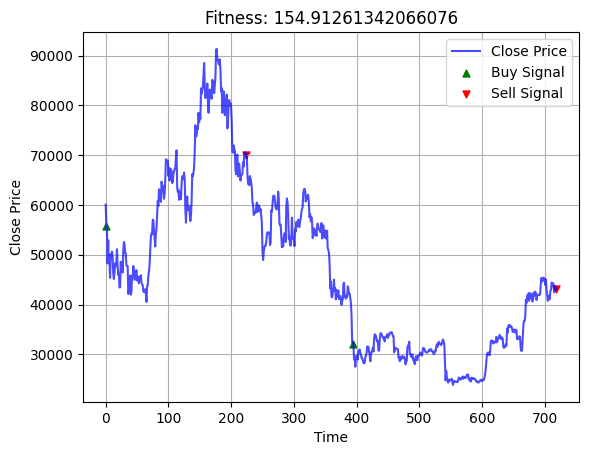

123.30218785247544


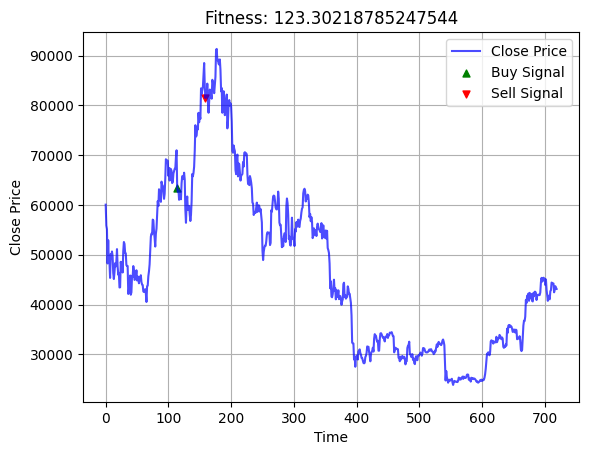

127.27119526554452


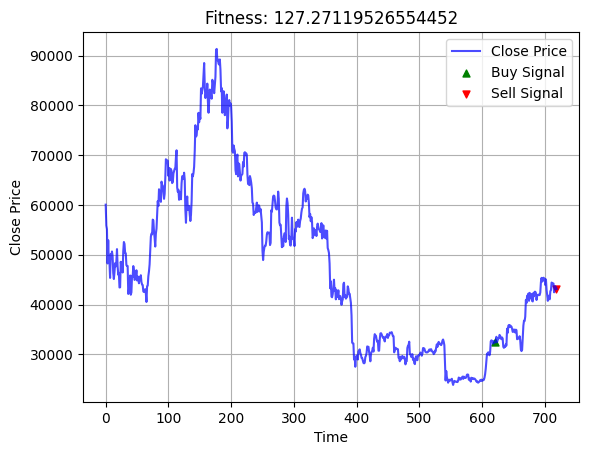

104.54938432293318


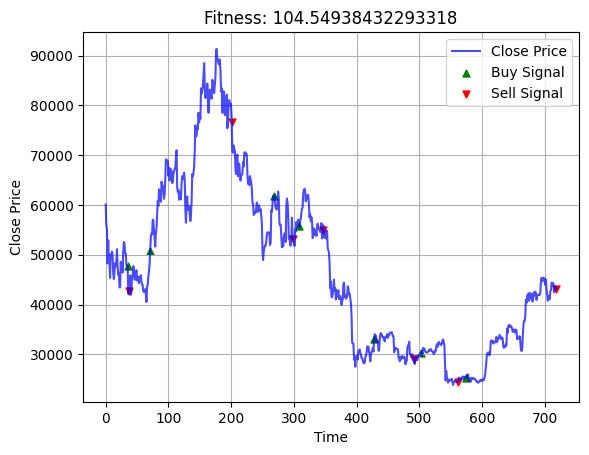

164.08559010051687


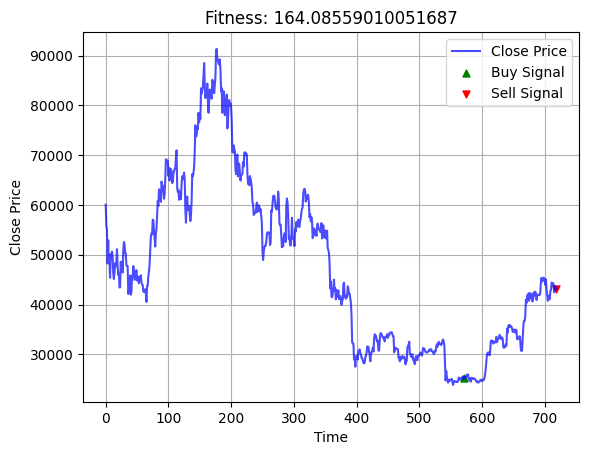

162.0496844761046


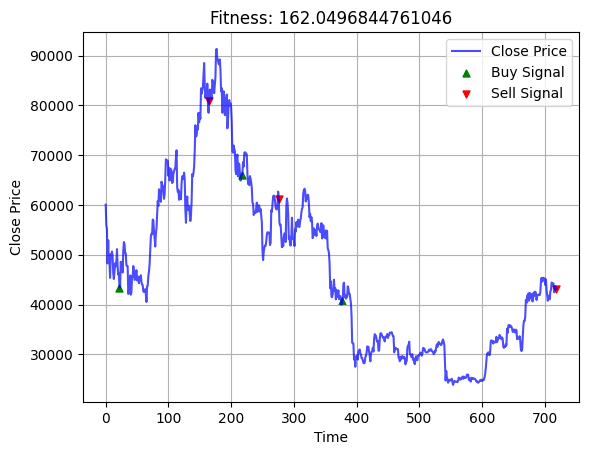

128.955946820806


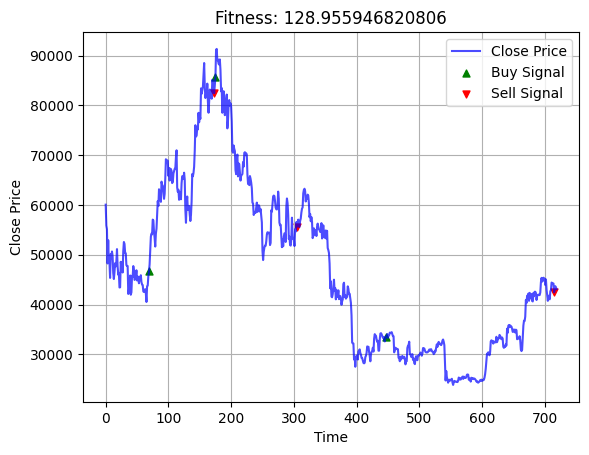

136.1283808872418


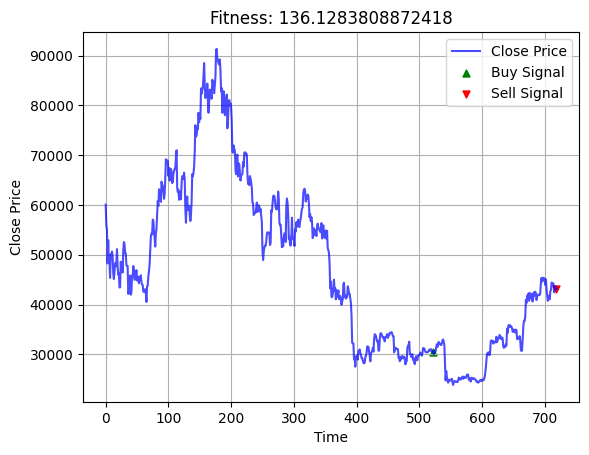

127.69951027811366


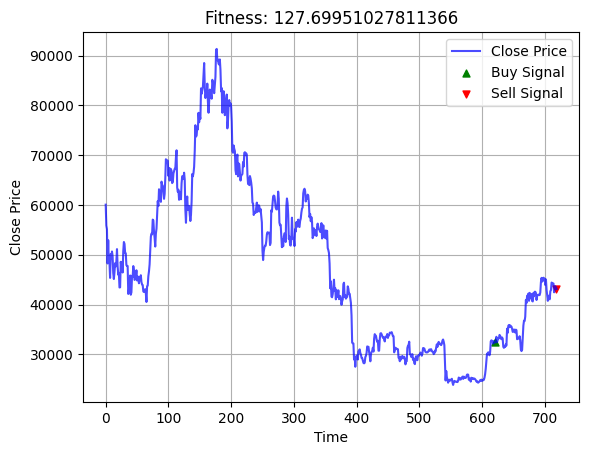

127.77055857943644


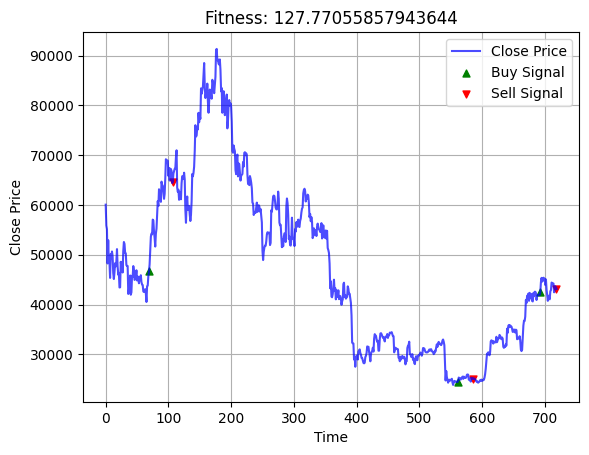

152.98629730071437


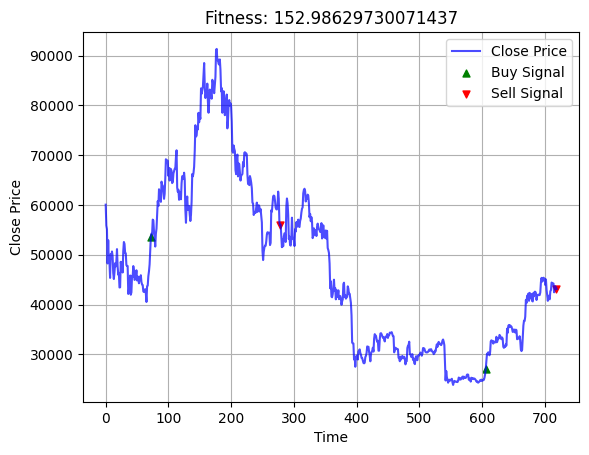

142.65265766428476


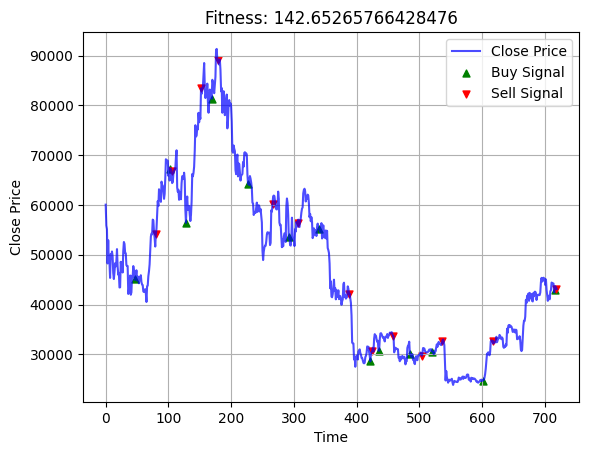

231.92286266424767


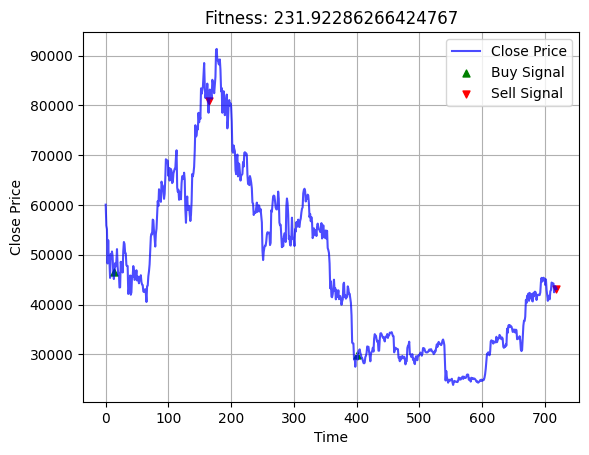

222.6991773249637


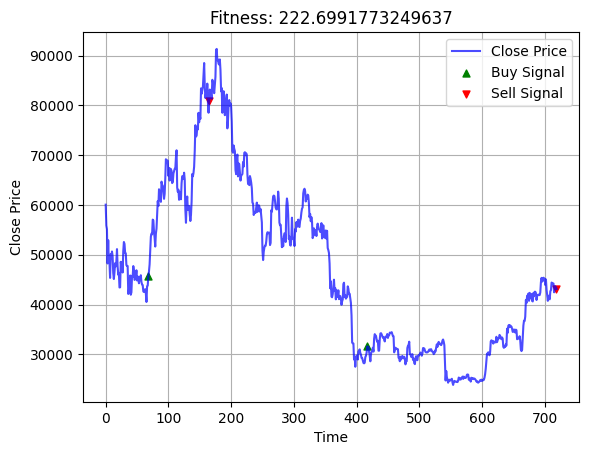

199.51245039246203


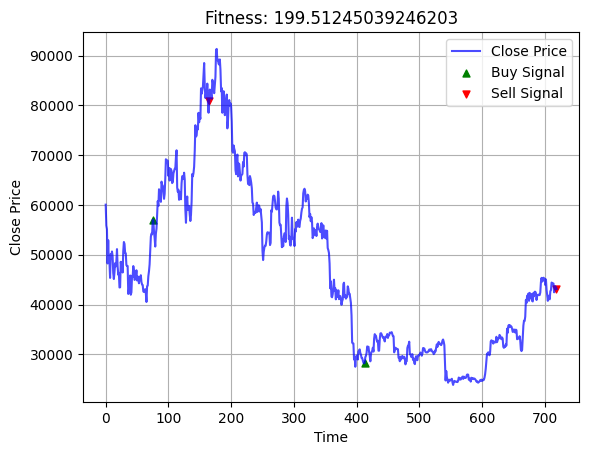

103.90383666024258


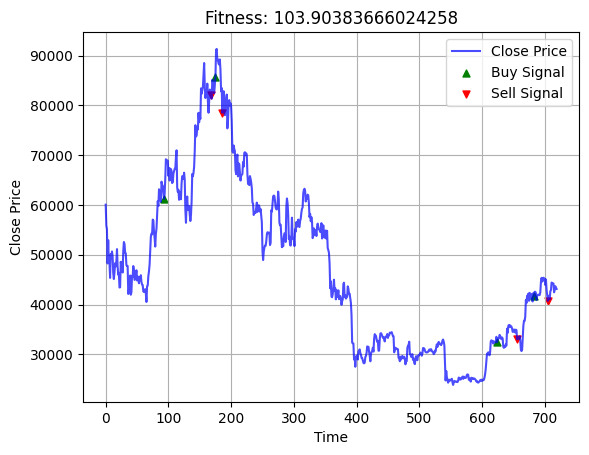

110.23563787494405


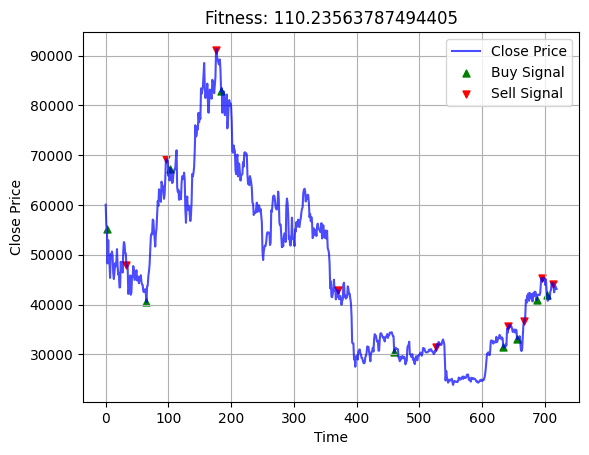

113.93379257005138


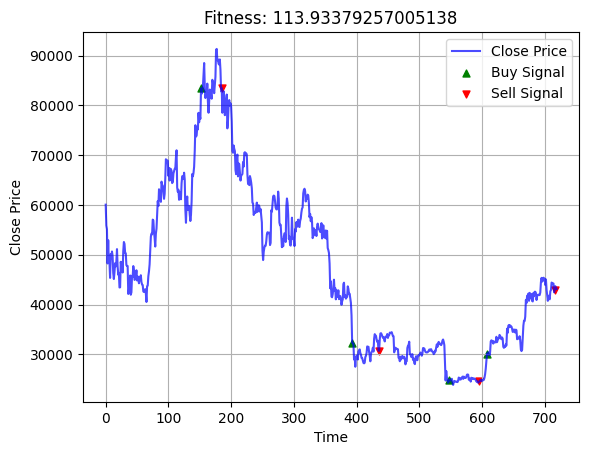

120.50025308521143


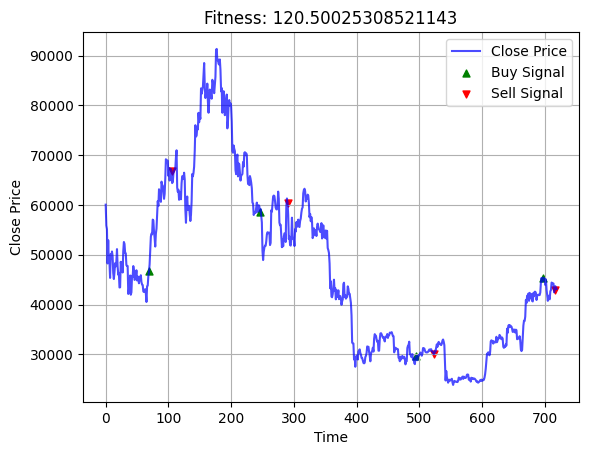

117.33978551654097


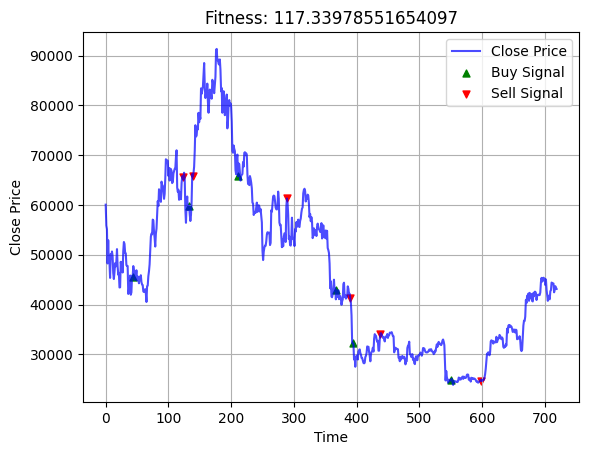

138.8319236292127


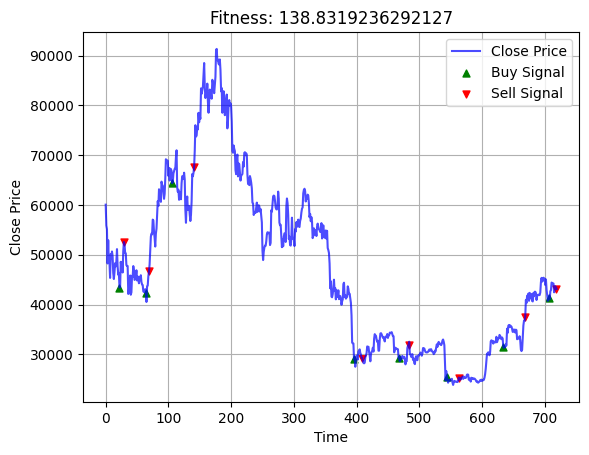

100.18644936975961


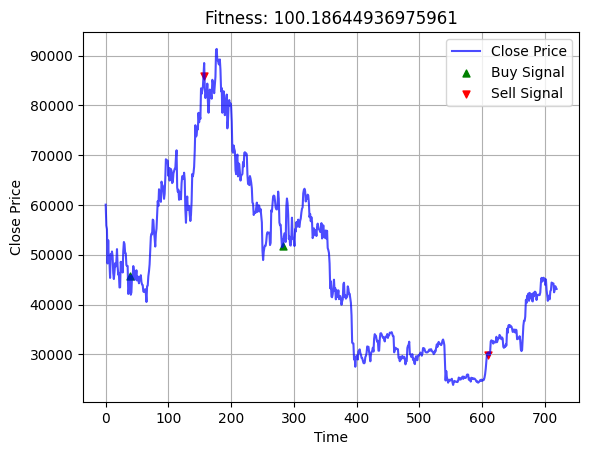

172.4188658862114


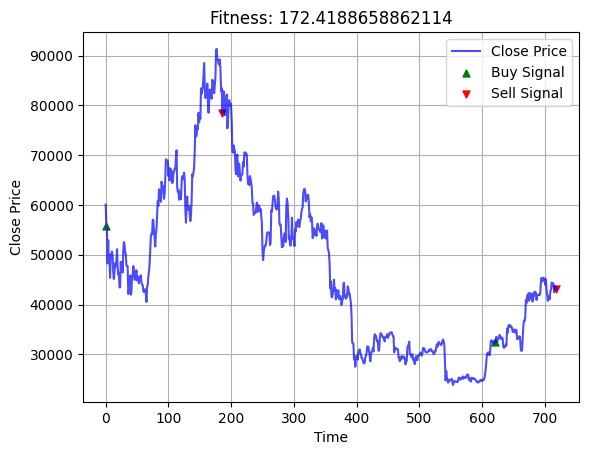

144.38237118503832


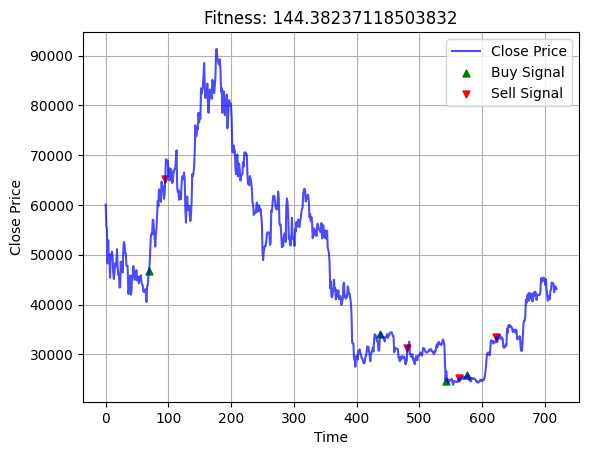

176.96989142688216


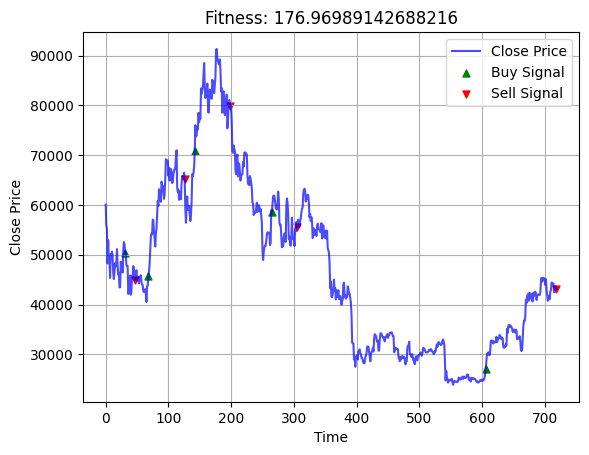

124.83290532861255


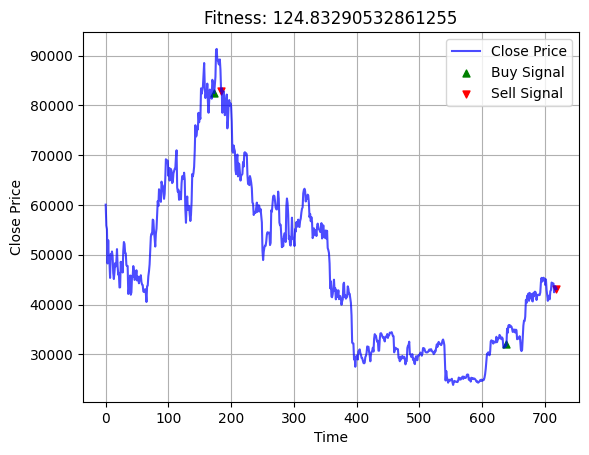

: 

In [1140]:
def numberOfEvents(positions):
    while len(positions) > 0 and positions[0][0] == 'sell':
        positions.pop(0)
    if len(positions) > 0:
        trimmed = [positions[0]]
        for i in range(1, len(positions)):
            if positions[i][0] != positions[i-1][0]:
                trimmed.append(positions[i])
    else:
        return positions
    return trimmed

for gene in goodGeneList:
    positions, fiat_money, btc_money = trading_bot(gene, ohlcv_data, from_day=0, to_day=719)
    #print(positions)
    positions = numberOfEvents(positions)



    print(fiat_money + (btc_money * ohlcv_data.iloc[-1]['c']))
    import matplotlib.pyplot as plt

    # Extract the timestamps, close prices, and buy/sell signals
    timestamps = ohlcv_data.index
    close_prices = ohlcv_data['c']
    buy_signals = [t for action, t in positions if action == 'buy']
    sell_signals = [t for action, t in positions if action == 'sell']

    # Plot the price data
    plt.plot(timestamps, close_prices, label='Close Price', color='blue', alpha=0.7)

    # Plot the buy signals
    plt.scatter([timestamps[t] for t in buy_signals],
                [close_prices[t] for t in buy_signals],
                color='g', s=25, marker="^", label='Buy Signal')

    # Plot the sell signals
    plt.scatter([timestamps[t] for t in sell_signals],
                [close_prices[t] for t in sell_signals],
                color='r', s=25, marker="v", label='Sell Signal')

    # Customize the plot appearance

    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title(f"Fitness: {fiat_money}")
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()